In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import Tracking_Py
import random
import pandas as pd

In [2]:
def print_h5_overview(file_path):
    with h5py.File(file_path, "r") as h5file:
        def visitor_func(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}")
                print(f"  Shape: {obj.shape}")
                print(f"  Data type: {obj.dtype}")
                print(f"  Sample data: {obj[()][:5]}")
            elif isinstance(obj, h5py.Group):
                print(f"Group: {name}")
                
        h5file.visititems(visitor_func)

In [3]:
def load_data(piv_file):
    
    # with h5py.File(common_filepath+"U_avg.h5", "r") as file:    
    #     U_avg = file["matrix"][:]
    # with h5py.File(common_filepath+"V_avg.h5", "r") as file:    
    #     V_avg = file["matrix"][:]
    # with h5py.File(common_filepath+"M_avg.h5", "r") as file:    
    #     M = file["matrix"][:]
    
    with h5py.File(piv_file, "r") as file:  
        # xgrid and ygrid data the same from original PIV results. 
        U_ori = file["U"][:]
        V_ori = file["V"][:]
        xgrid = file["xgrid"][:]
        ygrid = file["ygrid"][:]
    return U_ori, V_ori, xgrid, ygrid 

In [4]:
head_path = "/Users/rzhoufias.uni-frankfurt.de/Documents/PhD_Franziska/Headon/memGFP/"
U_control_1, V_control_1, xgrid_control_1, ygrid_control_1 = load_data(head_path + "memGFP_control/memGFP_control_1_PIV(IS=32_step=16).h5")
U_control_2, V_control_2, xgrid_control_2, ygrid_control_2 = load_data(head_path + "memGFP_control/memGFP_control_2_PIV(IS=32_step=16).h5")
U_control_3_condensate_cut, V_control_3_condensate_cut, xgrid_control_3_condensate_cut, ygrid_control_3_condensate_cut = load_data(head_path + "memGFP_control/memGFP_control_3(condensate_cut)_PIV(IS=32_step=16).h5")
U_control_3_with_condensate, V_control_3_with_condensate, xgrid_control_3_with_condensate, ygrid_control_3_condensate_cut = load_data(head_path + "memGFP_control/memGFP_control_3(with_condensate)_PIV(IS=32_step=16).h5")

In [5]:
U_DAPT_1, V_DAPT_1, xgrid_DAPT_1, ygrid_DAPT_1 = load_data(head_path + "memGFP_DAPT/memGFP_DAPT_1_PIV(IS=32_step=16).h5")
U_DAPT_2, V_DAPT_2, xgrid_DAPT_2, ygrid_DAPT_2 = load_data(head_path + "memGFP_DAPT/memGFP_DAPT_2_PIV(IS=32_step=16).h5")
U_DAPT_3, V_DAPT_3, xgrid_DAPT_3, ygrid_DAPT_3 = load_data(head_path + "memGFP_DAPT/memGFP_DAPT_3_PIV(IS=32_step=16).h5")

In [6]:
U_RA_1, V_RA_1, xgrid_RA_1, ygrid_RA_1 = load_data(head_path + "memGFP_RA/memGFP_RA_1_PIV(IS=32_step=16).h5")
U_RA_2, V_RA_2, xgrid_RA_2, ygrid_RA_2 = load_data(head_path + "memGFP_RA/memGFP_RA_2_PIV(IS=32_step=16).h5")
U_RA_4, V_RA_4, xgrid_RA_4, ygrid_RA_4 = load_data(head_path + "memGFP_RA/memGFP_RA_4_PIV(IS=32_step=16).h5")

# Pseudo Tracks on the whole image with random start points. 

Has the advantage that the tracks are not in one limited region of aggregates/vector fields. Allow more complete tracking and therefore less error with tracks (especially long tracks)

In [7]:
# Function to check if all values in an array are identical
def has_identical_values(arr):
    return np.all(arr == arr[0])

def whole_image_pseudo_trajectories(U, V, start_number, t0, t1, PIV_step, pxl_conversion, img_name):
    # Generate pseudo_trajectories for the whole image based on PIV results. 
    
    # Random starting points and the time. 
    start_x_array = [[random.randint(20,900)] for i in range(start_number)]
    start_y_array = [[random.randint(20,900)] for i in range(start_number)]

    t_array = [[t0, t1]]*len(start_x_array)
    
    # x and y coordinates of pseudo trajectories. 
    whole_img_x, whole_img_y = Tracking_Py.pseudo_tracking_piv_grid_v2(U, V, t_array,
                                                                  start_x_array,
                                                                  start_y_array, PIV_step)
    
    # Find out the points where there ist no movement -- either in x or y there should be movement (especially for the case of condensate!)
    arrays_to_filter = []
    for i, (x_array, y_array) in enumerate(zip(whole_img_x, whole_img_y)):
        # Check if there no displacement in both x and y directions. 
        if len(np.unique(x_array)) == 1 and len(np.unique(y_array)) == 1:
            arrays_to_filter.append(i)  # Store the index of matching arrays

    # Plotting. 
    plt.figure(figsize=(4,4), dpi=300)
    for i in range(len(start_x_array)): 
        if i not in arrays_to_filter: # Not plotting the points without movements.
            plt.scatter(start_x_array[i], start_y_array[i], color = "orange", s=4)
            plt.plot(whole_img_x[i], whole_img_y[i], color = "royalblue", alpha=0.5)
    plt.gca().invert_yaxis()
    plt.yticks([0, 500, 1000], (np.array([0, 500, 1000])*pxl_conversion).astype(int))
    plt.ylabel("distance (μm)")
    plt.xticks([0, 500, 1000], (np.array([0, 500, 1000])*pxl_conversion).astype(int))
    plt.xlabel("distance (μm)")
    # plt.savefig(img_name + ".svg", format="svg")
    plt.show()

    return whole_img_x, whole_img_y  # (start_number, time_points_number) dimensional numpy array. 

In [9]:
# x_coords, y_coords = whole_image_pseudo_trajectories(U_RA_4, V_RA_4, 500, 0, 48, 16, 0.69, "memGFP_RA_4_pseudo_tracks")

In [10]:
def pseudo_track_into_excel(x_coords, y_coords, img_name):
    # Turn the generated pseudo tracks data into excle data file (with the same format as manually generated track tables).
    # xx_coords, y_coords: the list contains numpy arrays recordings pseudo tracks coordinates. 
    # img_name: String. The name of data set applied for generating pseudo tracks.. 

    # Length of each array for x_coords and y_coords. 
    number_frame = np.shape(x_coords[0])[0]
    
    # Define the image name
    image_name = img_name
    
    # Prepare the data for the DataFrame
    data = {
        "Image_ID": [],
        "Track": [],
        "Frame": [],
        "X(pxl)": [],
        "Y(pxl)": []
    }
    
    # Populate the data dictionary
    for track_idx, (x_array, y_array) in enumerate(zip(x_coords, y_coords), start=1):
        for frame_idx, (x_val, y_val) in enumerate(zip(x_array, y_array), start=1):
            data["Image_ID"].append(image_name)
            data["Track"].append(track_idx)
            data["Frame"].append(frame_idx)
            data["X(pxl)"].append(x_val)
            data["Y(pxl)"].append(y_val)
    
    # Create a DataFrame and export it to Excel
    df = pd.DataFrame(data)
    df.to_excel(img_name + "_pseudo_tracks_table.xlsx", index=False)

In [11]:
# pseudo_track_into_excel(x_coords, y_coords, "memGFP_10_um_RA_4_(29.08.24)")

# Pseudo Tracks Analysis 
Measurement conversion: time between frames: 10 min, 1 pixel length/width = 0.69 μm. 
1. Speed (μm/min): The track length devided by the time
2. Euclidean distance: The Euclidean distance between start and end points for each track.
3. Persistence: Euclidean distance divided by the total distance travelled by the cell.
4. Absolut horizontal displacement: the absolut change of x component between start and end points for each track.
5. Absolut vertical displacement: the absoult change of y component between start and end points for each track. 
6. Collective displacement: The sum of the change of x and y components from all tracks for each data sample (counting positive and negative directions).

### General functions for 1, 2, 3

In [7]:
# The Euclidean distance between strat and end points for each pseudo trajectory.
# Without considering the measure conversion -- in pixel. 

def calculate_start_end_distance_pixel(x, y):
    # Calculate the Euclidean distance between the start and end points for a single track.
    start_x, end_x = x[0], x[-1]
    start_y, end_y = y[0], y[-1]
    distance = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
    return distance

In [8]:
# Calculate the track length for each pseudo trajectories. 
# Without considering the measure conversion -- in pixel.

def calculate_trajectory_length_pixel(x, y):
    # Calculate the differences between consecutive points for a single track.
    dx = np.diff(x)
    dy = np.diff(y)
    # Calculate the Euclidean distance for each segment and sum them
    length = np.sum(np.sqrt(dx**2 + dy**2))
    return length

### 1. Speed

Gather the speed data from all available data sets. Do violin plot with all speed data. Highlight the single data set with dots. 

In [9]:
# Speed calculation for one sample. 

def speed_calculation(x_coords, y_coords, time_conversion, pixel_conversion): 

    # Calculate the total time for trajectory. 
    frame_number = np.shape(x_coords)[1] - 1
    total_time = frame_number * time_conversion

    # Compute the length for each trajectory
    trajectory_lengths = np.array([calculate_trajectory_length_pixel(x, y) for x, y in zip(x_coords, y_coords)])
    # Take account into the measure conversion. Speed = total track length / total time
    trajectory_speed = trajectory_lengths * pixel_conversion / total_time

    return trajectory_speed

# speed = speed_calculation(x_coords, y_coords, 10, 0.69)

In [10]:
# Create an empty .h5 file for storing trajectory speed data cross different data set. 

# # Create an empty .h5 file
# with h5py.File("trajectory_speed.h5", "w") as h5file:
#     pass  # No data added yet

# Open the empty .h5 file in append mode to add datasets
# with h5py.File("trajectory_speed.h5", "a") as h5file:
#     # Add a dataset named by img_name. 
#     # del h5file["DAPT_3"] # Delete first if want to overwrite.
#     h5file.create_dataset("RA_4", data=speed)

# Overview of .h5 file containing speed information. 
speed_file_path = "/Users/rzhoufias.uni-frankfurt.de/Documents/PhD_Franziska/Headon/memGFP/statistical_data/statistical_data(15_11_24)/"
print_h5_overview(speed_file_path + "trajectory_speed.h5")

Dataset: DAPT_1
  Shape: (500,)
  Data type: float64
  Sample data: [0.08016442 0.11608879 0.11604663 0.07649827 0.06256234]
Dataset: DAPT_2
  Shape: (500,)
  Data type: float64
  Sample data: [0.05569919 0.07981877 0.07678492 0.0760845  0.09413625]
Dataset: DAPT_3
  Shape: (500,)
  Data type: float64
  Sample data: [0.09238787 0.12488392 0.07820858 0.12061416 0.13606534]
Dataset: RA_1
  Shape: (500,)
  Data type: float64
  Sample data: [0.06339805 0.07001948 0.06536785 0.06350963 0.0689759 ]
Dataset: RA_2
  Shape: (500,)
  Data type: float64
  Sample data: [0.1195162  0.13053807 0.13863882 0.1138358  0.12796275]
Dataset: RA_3
  Shape: (500,)
  Data type: float64
  Sample data: [0.06516749 0.16732329 0.11364459 0.11863304 0.11874935]
Dataset: RA_4
  Shape: (500,)
  Data type: float64
  Sample data: [0.13898752 0.12019579 0.13157263 0.11545238 0.12258627]
Dataset: control_1
  Shape: (500,)
  Data type: float64
  Sample data: [0.12975483 0.13235013 0.10437288 0.11583552 0.11262326]
Datas

In [11]:
with h5py.File(speed_file_path + "trajectory_speed.h5", "r") as file:  # Assume already know the .h5 data overview. Otherwise use the above overview function.
    # Data set under DAPT condition.
    speed_DAPT_1 = file["DAPT_1"][:]
    speed_DAPT_2 = file["DAPT_2"][:]
    speed_DAPT_3 = file["DAPT_3"][:]
    # Create the array containing all speed data. 
    speed_DAPT = np.concatenate([speed_DAPT_1, speed_DAPT_2, speed_DAPT_3])

    # Data set under RA condition. 
    speed_RA_1 = file["RA_1"][:]
    speed_RA_2 = file["RA_2"][:]
    speed_RA_4 = file["RA_4"][:]
    # Create the array containing all speed data. 
    speed_RA = np.concatenate([speed_RA_1, speed_RA_2, speed_RA_4])

    # Data set under control condition. 
    speed_control_1 = file["control_1"][:]
    speed_control_2 = file["control_2"][:]
    speed_control_3_condensate_cut = file["control_3(condensate_cut)"][:] # Have to filter out 0 because of condensates. 
    # Create the array containing all speed data. 
    speed_control = np.concatenate([speed_control_1, speed_control_2, speed_control_3_condensate_cut[speed_control_3_condensate_cut != 0]])

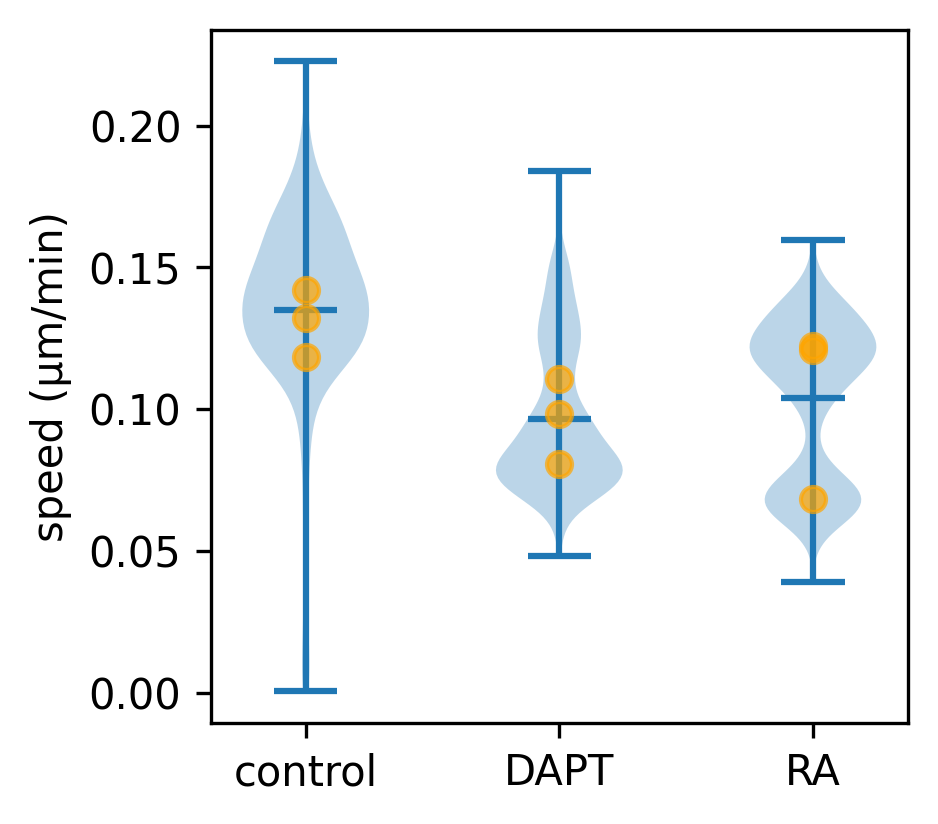

In [12]:
plt.figure(figsize=(3,3),dpi=300)
plt.violinplot([speed_control, speed_DAPT, speed_RA], showmeans=True) #, showmedians=True)

# Plot the mean of each simgle sample on the violin bars. 
# For control data set. 
plt.scatter([1]*3, [np.mean(speed_control_1), np.mean(speed_control_2), 
                    np.mean(speed_control_3_condensate_cut)], color="orange", alpha=0.7, zorder=2)
# For DAPT data set.
plt.scatter([2]*3, [np.mean(speed_DAPT_1), np.mean(speed_DAPT_2), 
                    np.mean(speed_DAPT_3)], color="orange", alpha=0.7, zorder=2)
# For RA data set. 
plt.scatter([3]*3, [np.mean(speed_RA_1), np.mean(speed_RA_2), 
                    # np.mean(speed_RA_3), 
                    np.mean(speed_RA_4)], color="orange", alpha=0.7, zorder=2)

# Customize the plot. 
plt.xticks([1, 2, 3], ["control", "DAPT", "RA"])  # Label each part
plt.yticks([0, 0.05, 0.1, 0.15, 0.2])
plt.ylabel("speed (μm/min)")
plt.savefig("pseudo_trajectory_speed(no_daft).svg", format="svg")

### 2. Euclidean Distance

Gather the Euclidean distance data from all available data sets. Do violin plot with all Euclidean data. Highlight the single data set with dots. 

In [13]:
def euclidean_distance_calculation(x_coords, y_coords, pixel_conversion):
    # Compute the start-to-end distance for each trajectory
    start_end_distances = np.array([calculate_start_end_distance_pixel(x, y) for x, y in zip(x_coords, y_coords)])
    return pixel_conversion * start_end_distances # Take the measure conversion into account. 

In [14]:
# euclidean_distance = euclidean_distance_calculation(x_coords, y_coords, 0.69)

In [15]:
# Create an empty .h5 file for storing Euclidean distance data cross different data set. 

# # Create an empty .h5 file
# with h5py.File("euclidean_distance.h5", "w") as h5file:
#     pass  # No data added yet

# Open the empty .h5 file in append mode to add datasets
# with h5py.File("euclidean_distance.h5", "a") as h5file:
#     # Add a dataset named by img_name. 
#     # del h5file["DAPT_3"] # Delete first if want to overwrite.
#     h5file.create_dataset("RA_4", data=euclidean_distance)

# Overview of .h5 file containing speed information. 
euc_dist_path = "/Users/rzhoufias.uni-frankfurt.de/Documents/PhD_Franziska/Headon/memGFP/statistical_data/statistical_data(15_11_24)/"
print_h5_overview(euc_dist_path + "euclidean_distance.h5")

Dataset: DAPT_1
  Shape: (500,)
  Data type: float64
  Sample data: [19.14637999 34.74077419 32.88847691 15.54321348 10.43469673]
Dataset: DAPT_2
  Shape: (500,)
  Data type: float64
  Sample data: [ 2.62884347 10.72300645 14.54461386  6.99732608  6.63937366]
Dataset: DAPT_3
  Shape: (500,)
  Data type: float64
  Sample data: [27.81464519 41.03147123 22.60624994 48.24122676 44.4518715 ]
Dataset: RA_1
  Shape: (500,)
  Data type: float64
  Sample data: [ 6.27509965 10.29936419  8.03458161  8.21244588  7.112068  ]
Dataset: RA_2
  Shape: (500,)
  Data type: float64
  Sample data: [ 9.7987521  13.17668762 15.24610333  4.65849168  9.59453326]
Dataset: RA_3
  Shape: (500,)
  Data type: float64
  Sample data: [14.92429631 74.07585916 38.06019406 45.9921715  35.66047836]
Dataset: RA_4
  Shape: (500,)
  Data type: float64
  Sample data: [30.66327339 29.73060136 46.3124811  30.41674626 37.73789004]
Dataset: control_1
  Shape: (500,)
  Data type: float64
  Sample data: [51.1703791  26.42893161 13

In [16]:
with h5py.File(euc_dist_path + "euclidean_distance.h5", "r") as file:  # Assume already know the .h5 data overview. Otherwise use the above overview function.
    # Data set under DAPT condition.
    dist_DAPT_1 = file["DAPT_1"][:]
    dist_DAPT_2 = file["DAPT_2"][:]
    dist_DAPT_3 = file["DAPT_3"][:]
    # Create the array containing all speed data. 
    dist_DAPT = np.concatenate([dist_DAPT_1, dist_DAPT_2, dist_DAPT_3])

    # Data set under RA condition. 
    dist_RA_1 = file["RA_1"][:]
    dist_RA_2 = file["RA_2"][:]
    dist_RA_4 = file["RA_4"][:]
    # Create the array containing all speed data. 
    dist_RA = np.concatenate([dist_RA_1, dist_RA_2, dist_RA_4])

    # Data set under control condition. 
    dist_control_1 = file["control_1"][:]
    dist_control_2 = file["control_2"][:]
    dist_control_3_condensate_cut = file["control_3(condensate_cut)"][:] # Have to filter out 0 because of condensates. 
    # Create the array containing all speed data. 
    dist_control = np.concatenate([dist_control_1, dist_control_2, dist_control_3_condensate_cut[dist_control_3_condensate_cut != 0]])

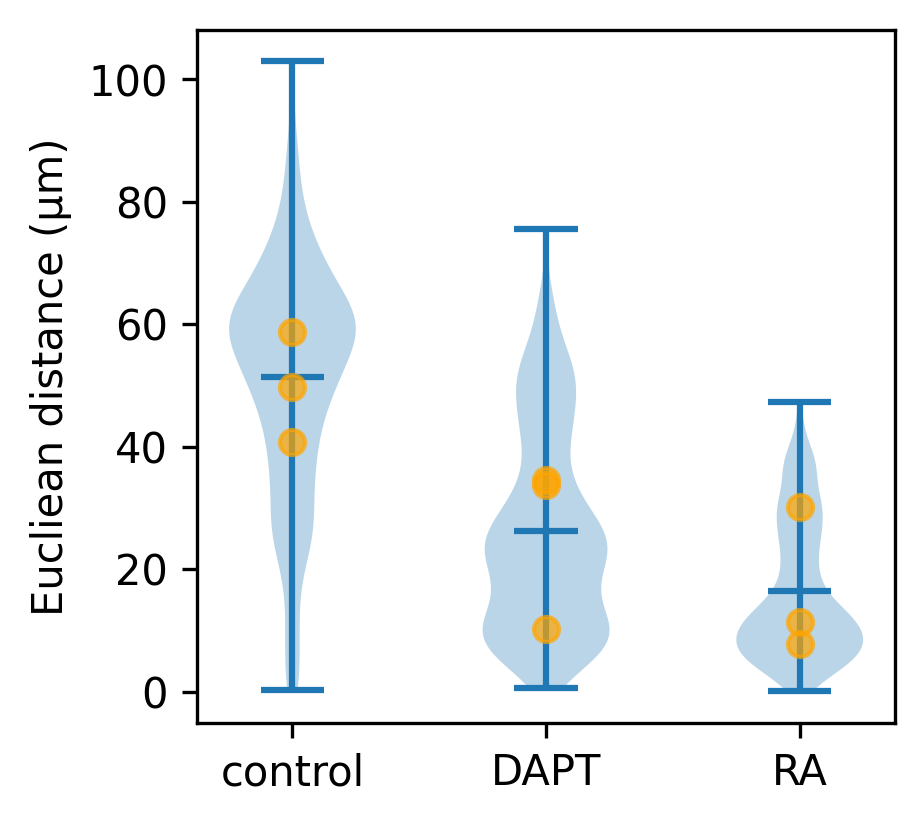

In [17]:
plt.figure(figsize=(3,3), dpi=300)
plt.violinplot([dist_control, dist_DAPT, dist_RA], showmeans=True)#, showmedians=True)

# Plot the mean of each simgle sample on the violin bars. 
# For control data set. 
plt.scatter([1]*3, [np.mean(dist_control_1), np.mean(dist_control_2), 
                    np.mean(dist_control_3_condensate_cut)], color="orange", alpha=0.7, zorder=2)
# For DAPT data set.
plt.scatter([2]*3, [np.mean(dist_DAPT_1), np.mean(dist_DAPT_2), 
                    np.mean(dist_DAPT_3)], color="orange", alpha=0.7, zorder=2)
# For RA data set. 
plt.scatter([3]*3, [np.mean(dist_RA_1), np.mean(dist_RA_2), 
                    np.mean(dist_RA_4)], color="orange", alpha=0.7, zorder=2)

# Customize the plot
plt.xticks([1, 2, 3], ["control", "DAPT", "RA"])  # Label each part
plt.yticks([0, 20, 40, 60, 80, 100])
plt.ylabel("Eucliean distance (μm)")
plt.savefig("pseudo_trajectory_Euclidean_distance(no_draft).svg", format="svg")

### 3. Persistence

Gather the persistence data from all available data sets. Do violin plot with all persistence data. Highlight the single data set with dots. 

In [18]:
def persistence(x_coords, y_coords): 

    # Euclidean Distance for each trajectory.
    start_end_distances = np.array([calculate_start_end_distance_pixel(x, y) for x, y in zip(x_coords, y_coords)])

    # Compute the length for each trajectory
    trajectory_lengths = np.array([calculate_trajectory_length_pixel(x, y) for x, y in zip(x_coords, y_coords)])

    # Persistence = Euclidean distance / trajectory length.  
    persistence = start_end_distances / trajectory_lengths
    # Filter out the NaN produced through deviding by 0. 
    # persistence_filtered = persistence[~np.isnan(persistence)]

    return persistence#persistence_filtered 

# x_coords, y_coords = whole_image_pseudo_trajectories(U_control_3_condensate_cut, 
#                                                       V_control_3_condensate_cut, 500, 0, 48, 16, 0.69, 
#                                                       "...")
# persistence = persistence(x_coords, y_coords)

In [19]:
# Create an empty .h5 file for storing persistence data cross different data set. 

# # Create an empty .h5 file
# with h5py.File("persistence.h5", "w") as h5file:
#     pass  # No data added yet

# Open the empty .h5 file in append mode to add datasets
# with h5py.File("persistence.h5", "a") as h5file:
#     # Add a dataset named by img_name. 
#     del h5file["control_3(condensate_cut)"] # Delete first if want to overwrite.
#     h5file.create_dataset("control_3(condensate_cut)", data=persistence)

# Overview of .h5 file containing speed information. 
persist_path = "/Users/rzhoufias.uni-frankfurt.de/Documents/PhD_Franziska/Headon/memGFP/statistical_data/statistical_data(15_11_24)/"
print_h5_overview(persist_path + "persistence.h5")

Dataset: DAPT_1
  Shape: (500,)
  Data type: float64
  Sample data: [0.49758102 0.62345913 0.59043215 0.42329967 0.34747664]
Dataset: DAPT_2
  Shape: (500,)
  Data type: float64
  Sample data: [0.09832741 0.27987898 0.39462541 0.19159965 0.14693626]
Dataset: DAPT_3
  Shape: (500,)
  Data type: float64
  Sample data: [0.62721632 0.6844935  0.60218912 0.83325669 0.68061464]
Dataset: RA_1
  Shape: (500,)
  Data type: float64
  Sample data: [0.20620704 0.30644343 0.25606948 0.26939634 0.21481137]
Dataset: RA_2
  Shape: (500,)
  Data type: float64
  Sample data: [0.17080586 0.21029445 0.22910405 0.08525605 0.15620648]
Dataset: RA_3
  Shape: (500,)
  Data type: float64
  Sample data: [0.4771134  0.92231454 0.69771969 0.80767567 0.62562584]
Dataset: RA_4
  Shape: (500,)
  Data type: float64
  Sample data: [0.4596227  0.51531548 0.73331617 0.5488689  0.64134919]
Dataset: control_1
  Shape: (500,)
  Data type: float64
  Sample data: [0.82158758 0.4160198  0.27518684 0.64580925 0.40389959]
Datas

In [20]:
with h5py.File(persist_path + "persistence.h5", "r") as file:  # Assume already know the .h5 data overview. Otherwise use the above overview function.
    # Data set under DAPT condition.
    persist_DAPT_1 = file["DAPT_1"][:]
    persist_DAPT_2 = file["DAPT_2"][:]
    persist_DAPT_3 = file["DAPT_3"][:]
    # Create the array containing all speed data. 
    persist_DAPT = np.concatenate([persist_DAPT_1, persist_DAPT_2, persist_DAPT_3])

    # Data set under RA condition. 
    persist_RA_1 = file["RA_1"][:]
    persist_RA_2 = file["RA_2"][:]
    persist_RA_4 = file["RA_4"][:]
    # Create the array containing all speed data. 
    persist_RA = np.concatenate([persist_RA_1, persist_RA_2, persist_RA_4])

    # Data set under control condition. 
    persist_control_1 = file["control_1"][:]
    persist_control_2 = file["control_2"][:]
    persist_control_3_condensate_cut = file["control_3(condensate_cut)"][:] # Have to filter out NaN because of condensates. 
    persist_control_3_condensate_cut = persist_control_3_condensate_cut[~np.isnan(persist_control_3_condensate_cut)]
    # Create the array containing all speed data. 
    persist_control = np.concatenate([persist_control_1, persist_control_2, 
                                    persist_control_3_condensate_cut])
    

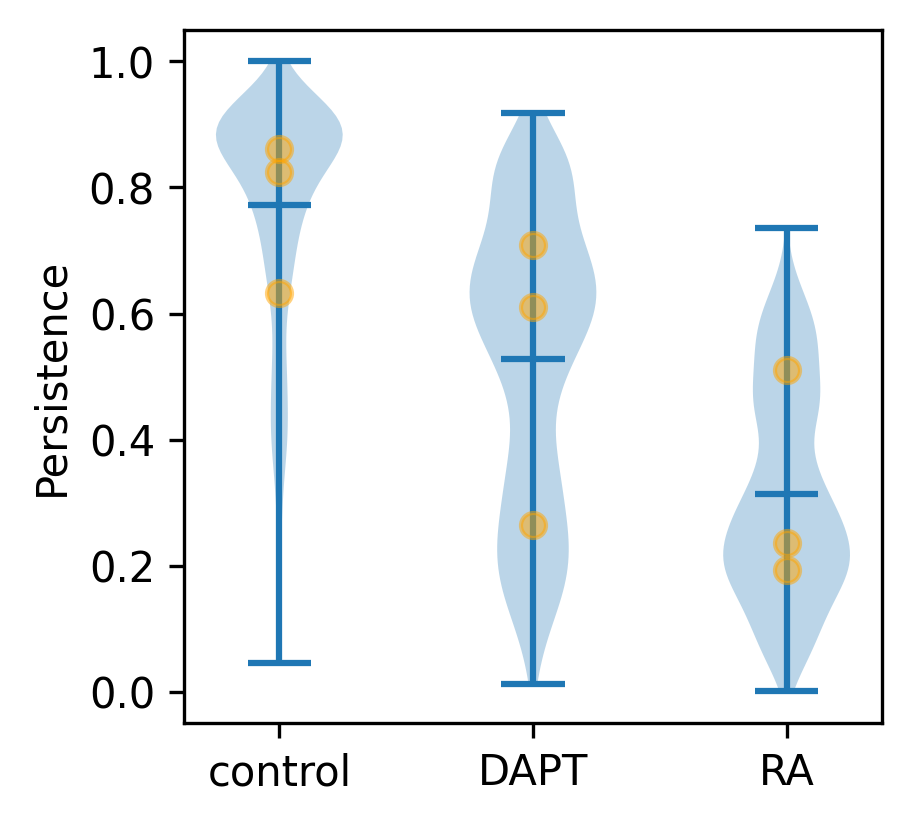

In [21]:
plt.figure(figsize=(3,3), dpi=300)
plt.violinplot([persist_control, persist_DAPT, persist_RA], showmeans=True)#, showmedians=True)

# Plot the mean of each simgle sample on the violin bars. 
# For control data set. 
plt.scatter([1]*3, [np.mean(persist_control_1), np.mean(persist_control_2), 
                    np.mean(persist_control_3_condensate_cut)], color="orange", alpha=0.5, zorder=2)
# For DAPT data set.
plt.scatter([2]*3, [np.mean(persist_DAPT_1), np.mean(persist_DAPT_2), 
                    np.mean(persist_DAPT_3)], color="orange", alpha=0.5, zorder=2)
# For RA data set. 
plt.scatter([3]*3, [np.mean(persist_RA_1), np.mean(persist_RA_2), 
                    np.mean(persist_RA_4)], color="orange", alpha=0.5, zorder=2)

# Customize the plot
plt.xticks([1, 2, 3], ["control", "DAPT", "RA"])  # Label each part
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylabel("Persistence")
plt.savefig("pseudo_trajectory_persistence(no_drift).svg", format="svg")

### 4. Absolut Horizontal Displacement 

In [22]:
def displacement_x_component(x):
    # Calculate the Euclidean distance between the start and end points for a single track.
    displacement_x = x[-1] - x[0] # Displacement: end point - start point. 
    return displacement_x

In [23]:
# Absolut horizontal displacement for one sample.
def absolut_horizontal_displacement(x_coords, y_coords, pixel_conversion): 
    absolut_displacement = np.array([np.abs(displacement_x_component(x)) * pixel_conversion for x in x_coords])
    return absolut_displacement

In [24]:
# Create an empty .h5 file for storing trajectory speed data cross different data set. 

# # Create an empty .h5 file
# with h5py.File("absolut_horizontal_displacement.h5", "w") as h5file:
#     pass  # No data added yet

# Open the empty .h5 file in append mode to add datasets
# with h5py.File("absolut_horizontal_displacement.h5", "a") as h5file:
#     # Add a dataset named by img_name. 
#     # del h5file["DAPT_3"] # Delete first if want to overwrite.
#     h5file.create_dataset("RA_4", data=absolut_displacement)

# Overview of .h5 file containing speed information. 
path = "/Users/rzhoufias.uni-frankfurt.de/Documents/PhD_Franziska/Headon/memGFP/statistical_data/statistical_data(15_11_24)/"
print_h5_overview(path + "absolute_horizontal_displacement.h5")

Dataset: DAPT_1
  Shape: (500,)
  Data type: float64
  Sample data: [32.0480118  48.25084696 17.68955717 24.19295217 48.63827509]
Dataset: DAPT_2
  Shape: (500,)
  Data type: float64
  Sample data: [ 1.93929017  7.02327444 12.50156597 14.42731287 13.17721699]
Dataset: DAPT_3
  Shape: (500,)
  Data type: float64
  Sample data: [50.28466842 26.54205657 49.90738946 26.14393949 53.17565566]
Dataset: RA_1
  Shape: (500,)
  Data type: float64
  Sample data: [ 3.8265866  12.57416297  2.13600627  0.50046765  5.83668661]
Dataset: RA_2
  Shape: (500,)
  Data type: float64
  Sample data: [13.7712092   6.03055022  6.39064887  5.04087224 15.22973075]
Dataset: RA_3
  Shape: (500,)
  Data type: float64
  Sample data: [39.86553038 58.82614561 72.62455881 58.68046562 55.49125821]
Dataset: RA_4
  Shape: (500,)
  Data type: float64
  Sample data: [18.60901605 10.99071425 15.56578354 18.35562611 23.87612866]
Dataset: control_1
  Shape: (500,)
  Data type: float64
  Sample data: [15.37930131 27.00357383  2

In [25]:
with h5py.File(path + "absolute_horizontal_displacement.h5", "r") as file:  # Assume already know the .h5 data overview. Otherwise use the above overview function.
    # Data set under DAPT condition.
    horizont_displace_DAPT_1 = file["DAPT_1"][:]
    horizont_displace_DAPT_2 = file["DAPT_2"][:]
    horizont_displace_DAPT_3 = file["DAPT_3"][:]
    # Create the array containing all speed data. 
    horizont_displace_DAPT = np.concatenate([horizont_displace_DAPT_1, horizont_displace_DAPT_2, horizont_displace_DAPT_3])

    # Data set under RA condition. 
    horizont_displace_RA_1 = file["RA_1"][:]
    horizont_displace_RA_2 = file["RA_2"][:]
    horizont_displace_RA_4 = file["RA_4"][:]
    # Create the array containing all speed data. 
    horizont_displace_RA = np.concatenate([horizont_displace_RA_1, horizont_displace_RA_2, horizont_displace_RA_4])

    # Data set under control condition. 
    horizont_displace_control_1 = file["control_1"][:]
    horizont_displace_control_2 = file["control_2"][:]
    horizont_displace_control_3_condensate_cut = file["control_3(condensate_cut)"][:] # Have to filter out 0 because of condensates. 
    # Create the array containing all speed data. 
    horizont_displace_control = np.concatenate([horizont_displace_control_1, horizont_displace_control_2, 
                                                horizont_displace_control_3_condensate_cut])

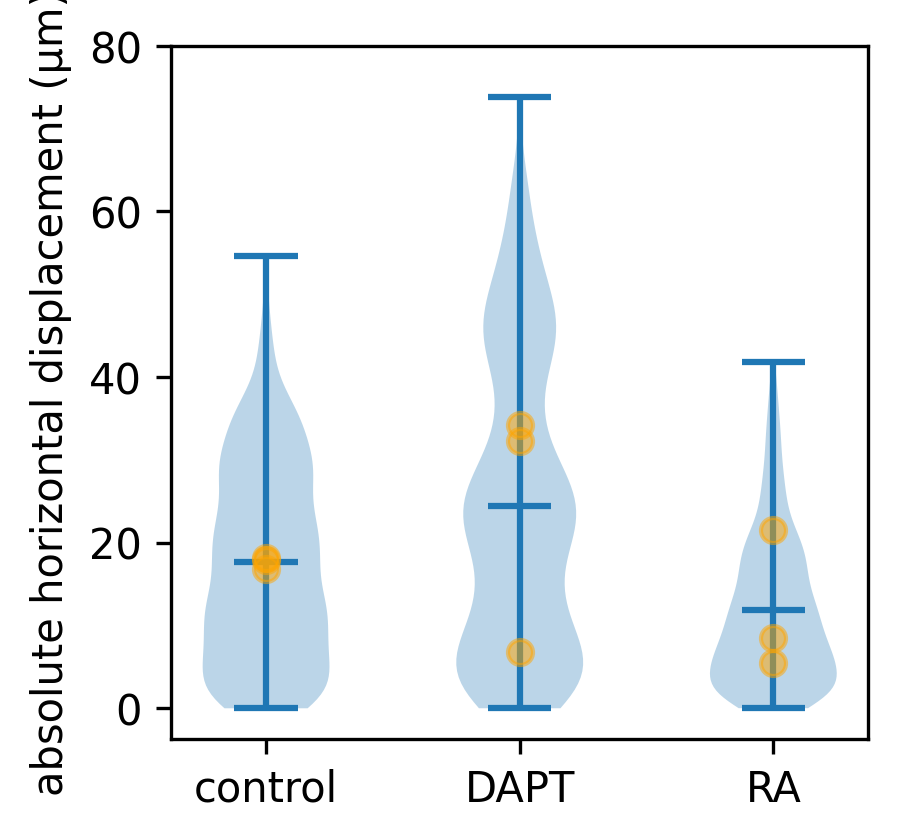

In [26]:
plt.figure(figsize=(3,3),dpi=300)
plt.violinplot([horizont_displace_control, horizont_displace_DAPT, horizont_displace_RA], showmeans=True) #, showmedians=True)

# Plot the mean of each simgle sample on the violin bars. 
# For control data set. 
plt.scatter([1]*3, [np.mean(horizont_displace_control_1), np.mean(horizont_displace_control_2), 
                    np.mean(horizont_displace_control_3_condensate_cut)], color="orange", alpha=0.5, zorder=2)
# For DAPT data set.
plt.scatter([2]*3, [np.mean(horizont_displace_DAPT_1), np.mean(horizont_displace_DAPT_2), 
                    np.mean(horizont_displace_DAPT_3)], color="orange", alpha=0.5, zorder=2)
# For RA data set. 
plt.scatter([3]*3, [np.mean(horizont_displace_RA_1), np.mean(horizont_displace_RA_2), 
                    np.mean(horizont_displace_RA_4)], color="orange", alpha=0.5, zorder=2)

# Customize the plot. 
plt.xticks([1, 2, 3], ["control", "DAPT", "RA"])  # Label each part
plt.yticks([0, 20, 40, 60, 80])
plt.ylabel("absolute horizontal displacement (μm)")
plt.savefig("pseudo_track_absolute_horizontal_displacement(no_drift).svg", format="svg")

### 5. Absolut vertical displacement 

In [27]:
def displacement_y_component(y):
    # Calculate the Euclidean distance between the start and end points for a single track.
    displacement_y = y[-1] - y[0] # Displacement: end point - start point. 
    return displacement_y

# Absolut horizontal displacement for one sample.
def absolut_vertical_displacement(y_coords, pixel_conversion): 
    absolut_displacement = np.array([np.abs(displacement_y_component(y)) * pixel_conversion for y in y_coords])
    return absolut_displacement

In [28]:
# Create an empty .h5 file for storing trajectory speed data cross different data set. 

# Create an empty .h5 file
# with h5py.File("absolut_vertical_displacement.h5", "w") as h5file:
#     pass  # No data added yet

# x_coords, y_coords = whole_image_pseudo_trajectories(U_RA_2, V_RA_2, 500, 0, 48, 16, 0.69, "...")
# absolut_displacement = absolut_vertical_displacement(y_coords, 0.69)

# with h5py.File("absolut_vertical_displacement.h5", "a") as h5file:
#     # Add a dataset named by img_name. 
#     # del h5file["DAPT_3"] # Delete first if want to overwrite.
#     h5file.create_dataset("RA_2", data=absolut_displacement)

# Overview of .h5 file containing speed information. 
path = "/Users/rzhoufias.uni-frankfurt.de/Documents/PhD_Franziska/Headon/memGFP/statistical_data/statistical_data(15_11_24)/"
print_h5_overview(path + "absolute_vertical_displacement.h5")

Dataset: DAPT_1
  Shape: (500,)
  Data type: float64
  Sample data: [17.2163241  12.29711991  2.53365563  0.32328209  9.76972586]
Dataset: DAPT_2
  Shape: (500,)
  Data type: float64
  Sample data: [12.50532826 10.25020897 15.80668086  7.74192065  2.8476645 ]
Dataset: DAPT_3
  Shape: (500,)
  Data type: float64
  Sample data: [11.07990278  0.99972474  1.4102548  13.74754359  1.03767304]
Dataset: RA_1
  Shape: (500,)
  Data type: float64
  Sample data: [5.667457   0.12148002 3.74522802 4.69944389 5.00860796]
Dataset: RA_2
  Shape: (500,)
  Data type: float64
  Sample data: [5.31060651 5.57550431 2.38373747 8.39975998 1.13372859]
Dataset: RA_3
  Shape: (500,)
  Data type: float64
  Sample data: [ 7.23138204 26.5479008  29.78294141 26.51341883 23.7766626 ]
Dataset: RA_4
  Shape: (500,)
  Data type: float64
  Sample data: [21.64434092 27.41695127 25.37487308 29.21794449  5.40409549]
Dataset: control_1
  Shape: (500,)
  Data type: float64
  Sample data: [33.71516371 28.55550783 21.54158808 

In [29]:
with h5py.File(path + "absolute_vertical_displacement.h5", "r") as file:  # Assume already know the .h5 data overview. Otherwise use the above overview function.
    # Data set under DAPT condition.
    vertical_displace_DAPT_1 = file["DAPT_1"][:]
    vertical_displace_DAPT_2 = file["DAPT_2"][:]
    vertical_displace_DAPT_3 = file["DAPT_3"][:]
    # Create the array containing all speed data. 
    vertical_displace_DAPT = np.concatenate([vertical_displace_DAPT_1, vertical_displace_DAPT_2, vertical_displace_DAPT_3])

    # Data set under RA condition. 
    vertical_displace_RA_1 = file["RA_1"][:]
    vertical_displace_RA_2 = file["RA_2"][:]
    vertical_displace_RA_4 = file["RA_4"][:]
    # Create the array containing all speed data. 
    vertical_displace_RA = np.concatenate([vertical_displace_RA_1, vertical_displace_RA_2, vertical_displace_RA_4])

    # Data set under control condition. 
    vertical_displace_control_1 = file["control_1"][:]
    vertical_displace_control_2 = file["control_2"][:]
    vertical_displace_control_3_condensate_cut = file["control_3_condensate_cut"][:] # Have to filter out 0 because of condensates. 
    # Create the array containing all speed data. 
    vertical_displace_control = np.concatenate([vertical_displace_control_1, vertical_displace_control_2, 
                                                vertical_displace_control_3_condensate_cut])

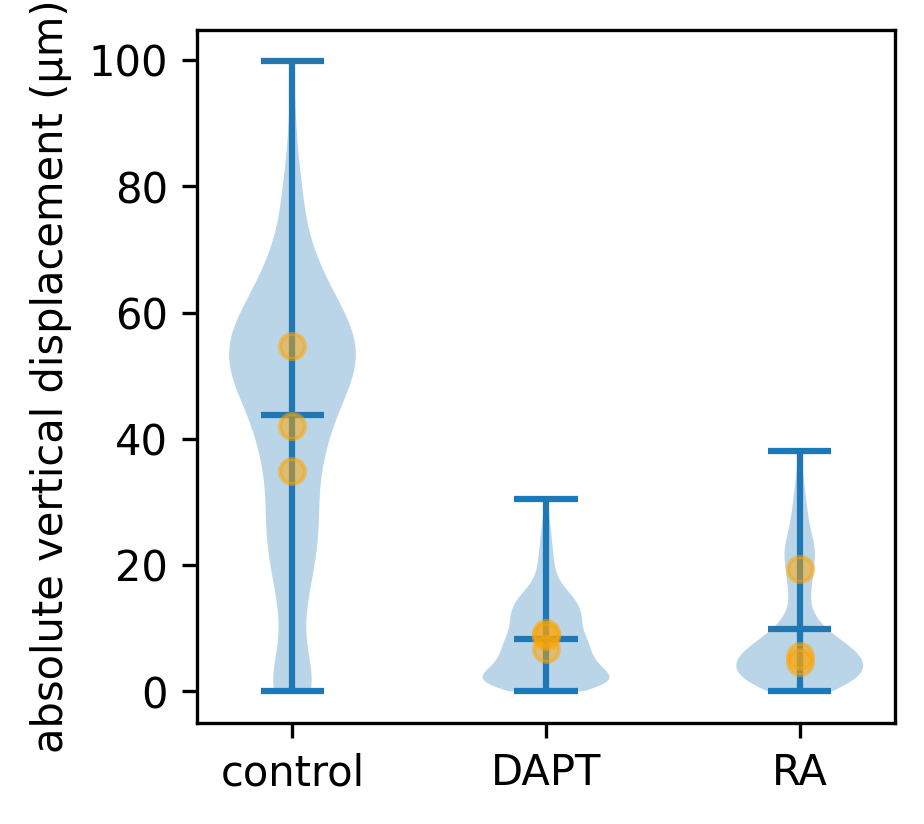

In [30]:
plt.figure(figsize=(3,3),dpi=300)
plt.violinplot([vertical_displace_control, vertical_displace_DAPT, vertical_displace_RA], showmeans=True) #, showmedians=True)

# Plot the mean of each simgle sample on the violin bars. 
# For control data set. 
plt.scatter([1]*3, [np.mean(vertical_displace_control_1), np.mean(vertical_displace_control_2), 
                    np.mean(vertical_displace_control_3_condensate_cut)], color="orange", alpha=0.5, zorder=2)
# For DAPT data set.
plt.scatter([2]*3, [np.mean(vertical_displace_DAPT_1), np.mean(vertical_displace_DAPT_2), 
                    np.mean(vertical_displace_DAPT_3)], color="orange", alpha=0.5, zorder=2)
# For RA data set. 
plt.scatter([3]*3, [np.mean(vertical_displace_RA_1), np.mean(vertical_displace_RA_2), 
                    np.mean(vertical_displace_RA_4)], color="orange", alpha=0.5, zorder=2)

# Customize the plot. 
plt.xticks([1, 2, 3], ["control", "DAPT", "RA"])  # Label each part
plt.yticks([0, 20, 40, 60, 80, 100])
plt.ylabel("absolute vertical displacement (μm)")
plt.savefig("pseudo_track_absolute_vertical_displacement(no_drift).svg", format="svg")

### 6. Collective Displacement

In [ ]:
def displacement_x_component(x):
    # Calculate the Euclidean distance between the start and end points for a single track.
    displacement_x = x[-1] - x[0] # Displacement: end point - start point. 
    return displacement_x

In [ ]:
def displacement_y_component(y):
    # Calculate the Euclidean distance between the start and end points for a single track.
    displacement_y = y[-1] - y[0] # Displacement: end point - start point. 
    return displacement_y

In [ ]:
# Displacement (counting direction) for one sample data. 

def directed_displacement(x_coords, y_coords, pixel_conversion):
    # Calculate the displacement in x and y components.
    final_displacement_x_component = np.sum(np.array([displacement_x_component(x) for x in x_coords]))
    final_displacement_y_component = np.sum(np.array([displacement_y_component(y) for y in y_coords]))
    # Sum will not be 0 (through observation).
    final_displacement = np.sqrt(final_displacement_x_component**2 + final_displacement_y_component**2) * pixel_conversion
    return final_displacement

In [ ]:
# Results from control data.
x_coords_control_1, y_coords_control_1 = whole_image_pseudo_trajectories(U_control_1, V_control_1, 500, 0, 48, 16, 0.69, "...")
x_coords_control_2, y_coords_control_2 = whole_image_pseudo_trajectories(U_control_2, V_control_2, 500, 0, 48, 16, 0.69, "...")
x_coords_control_3_condensate_cut, y_coords_control_3_condensate_cut = whole_image_pseudo_trajectories(U_control_3_condensate_cut, 
                                                                                                       V_control_3_condensate_cut, 500, 0, 48, 16, 0.69, "...")
control_displacement = np.array([directed_displacement(x_coords_control_1, y_coords_control_1, 0.69),
                                directed_displacement(x_coords_control_2, y_coords_control_2, 0.69),
                                directed_displacement(x_coords_control_3_condensate_cut, y_coords_control_3_condensate_cut, 0.69)])


# Results from DAPT data.
x_coords_DAPT_1, y_coords_DAPT_1 = whole_image_pseudo_trajectories(U_DAPT_1, V_DAPT_1, 500, 0, 48, 16, 0.69, "...")
x_coords_DAPT_2, y_coords_DAPT_2 = whole_image_pseudo_trajectories(U_DAPT_2, V_DAPT_2, 500, 0, 48, 16, 0.69, "...")
x_coords_DAPT_3, y_coords_DAPT_3 = whole_image_pseudo_trajectories(U_DAPT_3, V_DAPT_3, 500, 0, 48, 16, 0.69, "...")

DAPT_displacement = np.array([directed_displacement(x_coords_DAPT_1, y_coords_DAPT_2, 0.69), 
                             directed_displacement(x_coords_DAPT_2, y_coords_DAPT_2, 0.69), 
                             directed_displacement(x_coords_DAPT_3, y_coords_DAPT_3, 0.69)])

# Results from RA data. 
x_coords_RA_1, y_coords_RA_1 = whole_image_pseudo_trajectories(U_RA_1, V_RA_1, 500, 0, 48, 16, 0.69, "...")
x_coords_RA_2, y_coords_RA_2 = whole_image_pseudo_trajectories(U_RA_2, V_RA_2, 500, 0, 48, 16, 0.69, "...")
x_coords_RA_4, y_coords_RA_4 = whole_image_pseudo_trajectories(U_RA_4, V_RA_4, 500, 0, 48, 16, 0.69, "...")

RA_displacement = np.array([directed_displacement(x_coords_RA_1, y_coords_RA_1, 0.69), 
                           directed_displacement(x_coords_RA_2, y_coords_RA_2, 0.69),  
                           directed_displacement(x_coords_RA_4, y_coords_RA_4, 0.69)])

In [ ]:
# Combine arrays for easier processing and calculate the mean for each condition. 
num_pseudo_tracks = 500 # Average through the number of tracks. 
displacement_data = [control_displacement/num_pseudo_tracks, DAPT_displacement/num_pseudo_tracks, RA_displacement/num_pseudo_tracks]
means = [np.mean(arr) for arr in displacement_data]

# Set up the plot
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

# Plot each array's points as dots and mean as a bar
x_positions = [1, 2, 3]  # Positions for the three arrays

for i, arr in enumerate(displacement_data):
    # Scatter individual points
    x_vals = np.full(arr.shape, x_positions[i])  # position each point in the correct x-location
    ax.scatter(x_vals, arr, color='orange', label='samples' if i == 0 else "")  # only label first set of points
    
    # Plot mean as a line
    ax.hlines(means[i], x_positions[i] - 0.2, x_positions[i] + 0.2, colors='tab:blue', linewidth=2, label='mean' if i == 0 else "")

# Customize plot
ax.set_xticks(x_positions)
ax.set_xticklabels(['control', 'DAPT', 'RA'])
ax.set_ylabel('average total displacement (μm)')
ax.legend()
plt.savefig("pseudo_track_average_total_displacement(no_drift).svg", format="svg")
plt.show()

### 7. Rose Plots of the Moving Direction.

In [8]:
def displace_angle_multiple_tracks(track_x_coord, track_y_coord):
    # Calculate the displacement direction of all tracks given in the track x and y coordinates. 

    # Calculate the displacement in x direction. 
    Δx = np.array([arr[-1]-arr[0] for arr in track_x_coord])
    # Calculate the displacement in y direction.
    Δy = np.array([arr[-1]-arr[0] for arr in track_y_coord])

    angles = np.arctan2(-Δy, Δx) # Have to take the -Δy because of the flipping of y axis. 

    # Return the angles and the Euclidean distance of all tracks. 
    return angles, np.sqrt(Δx**2 + Δy**2)

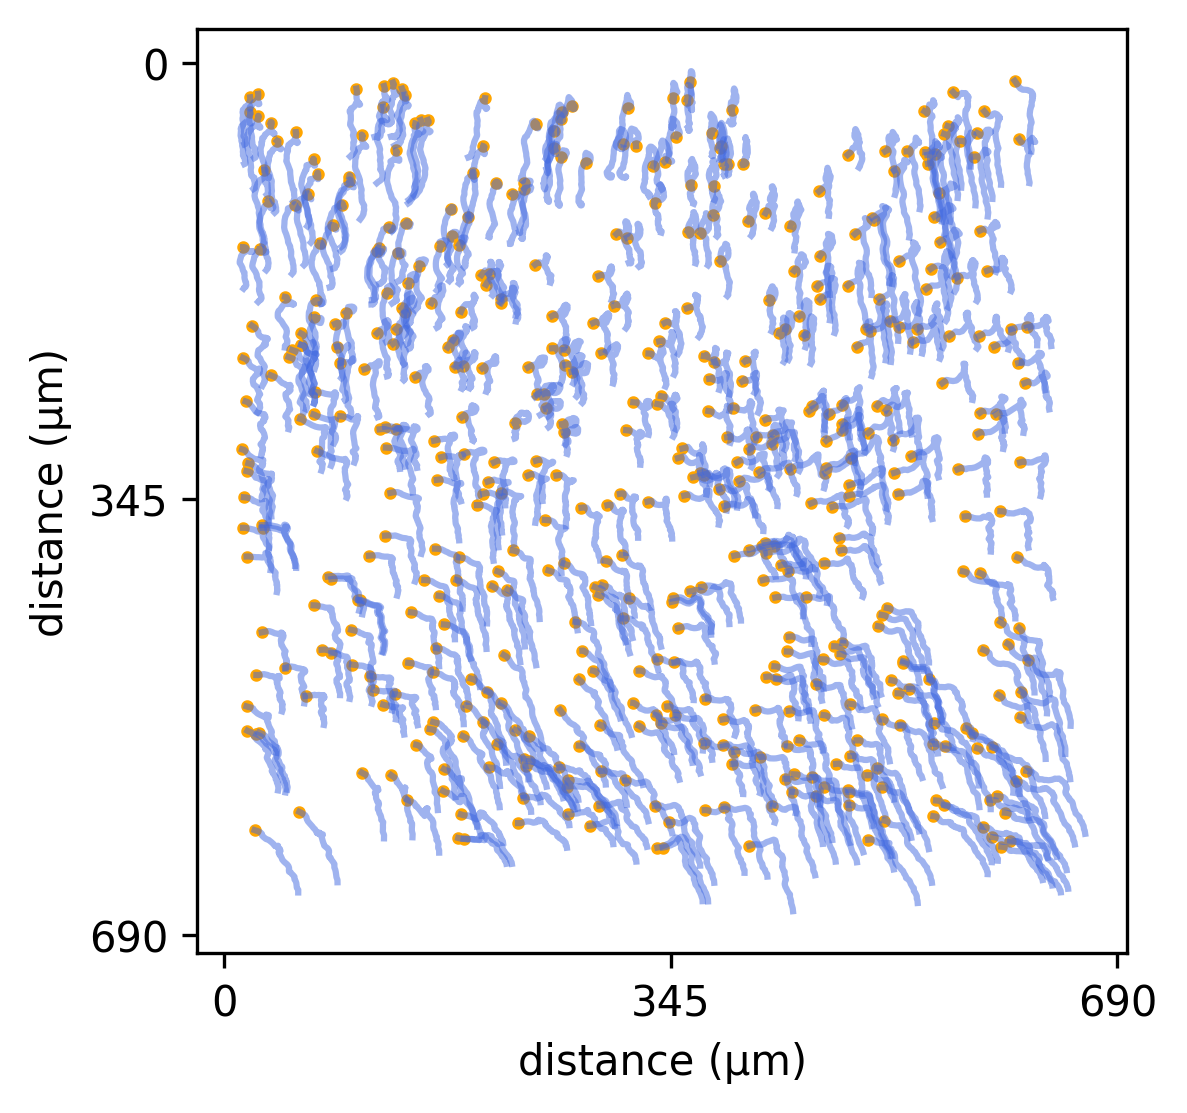

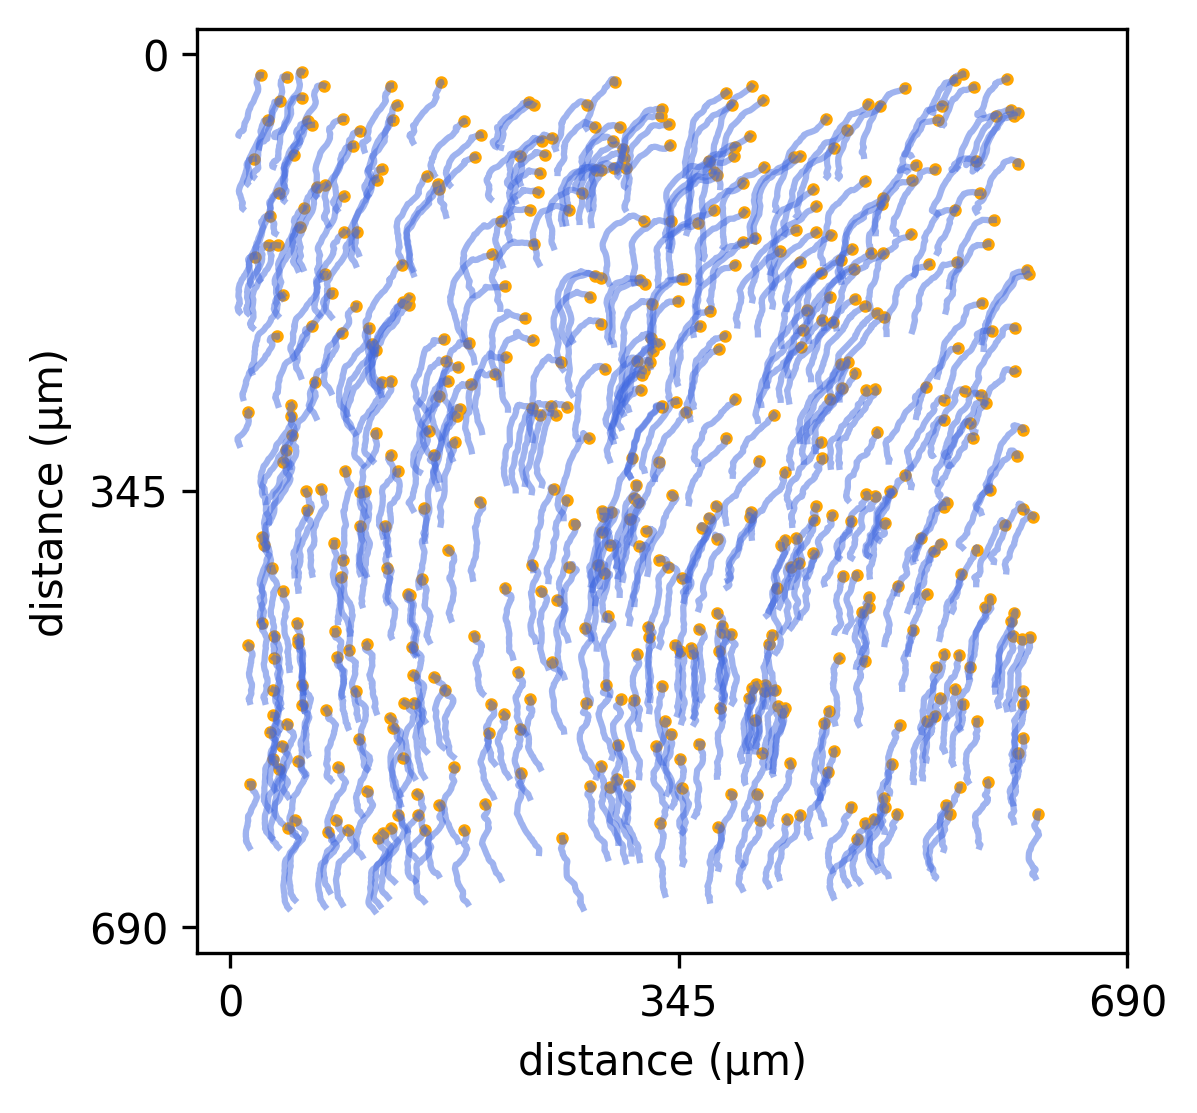

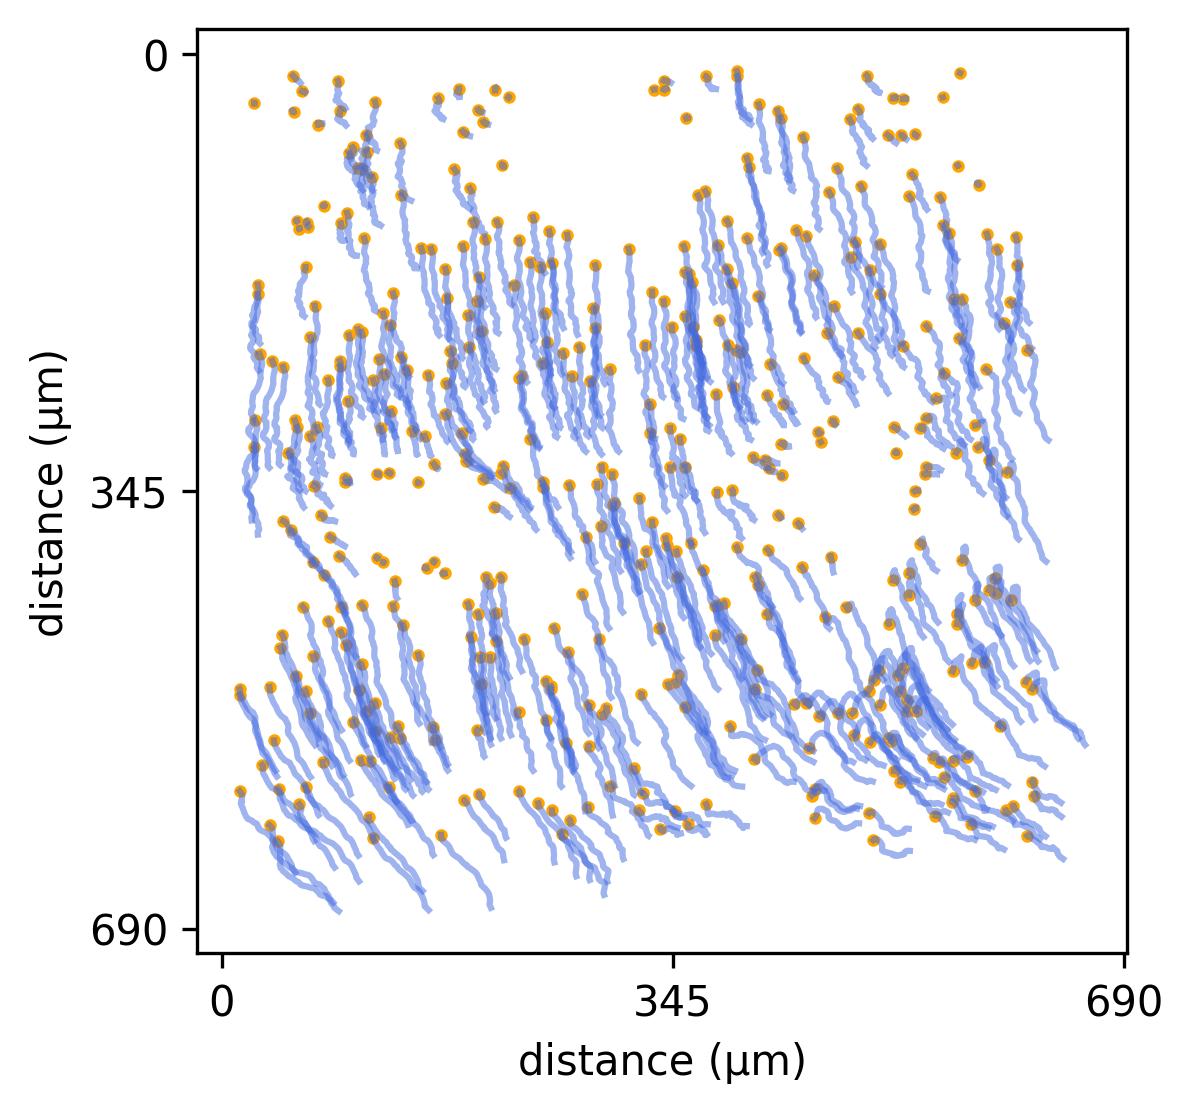

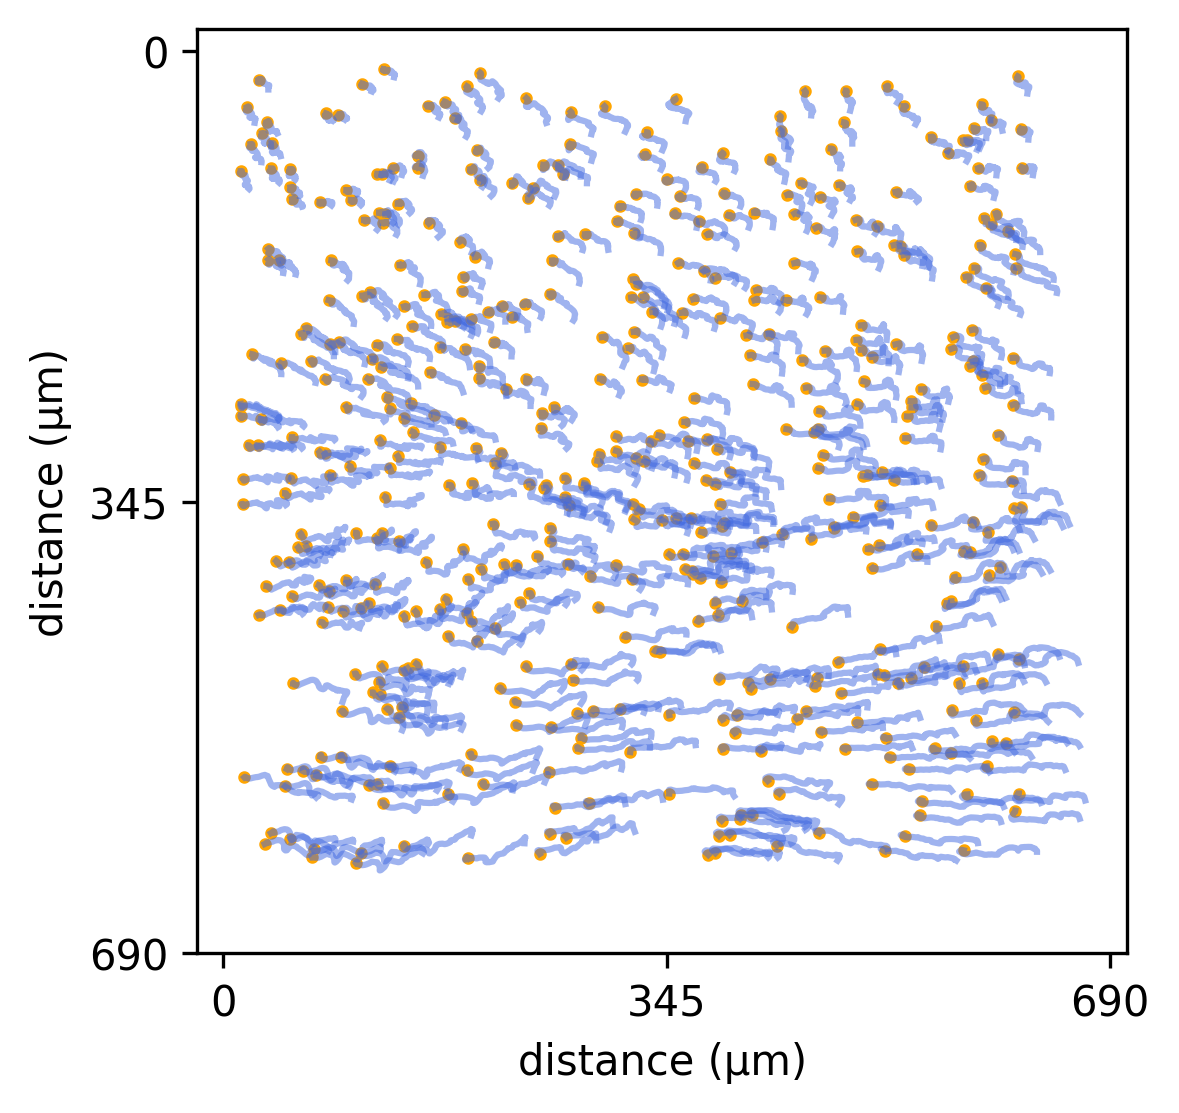

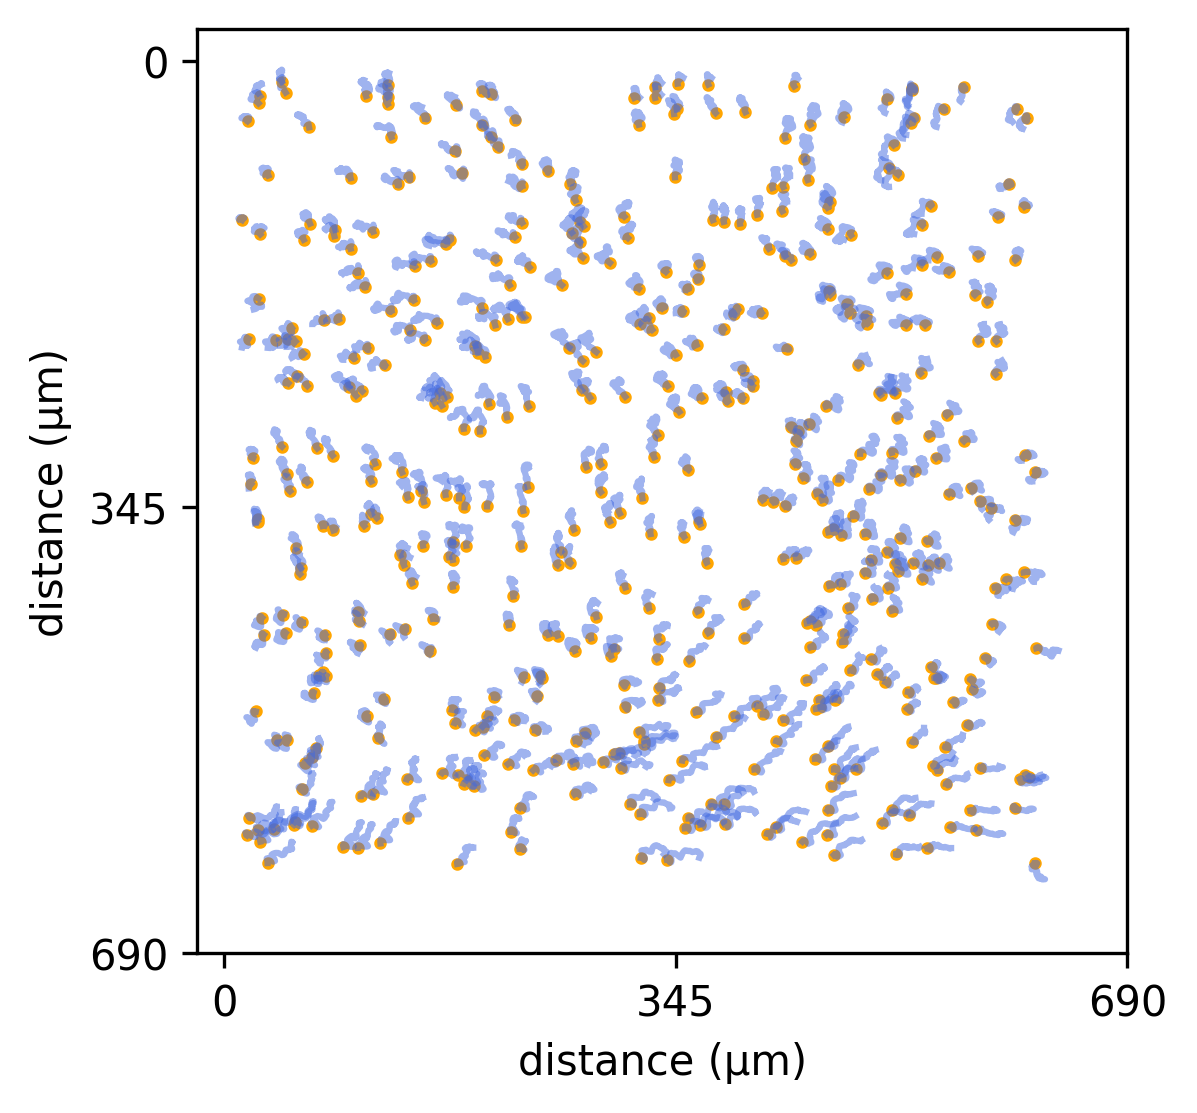

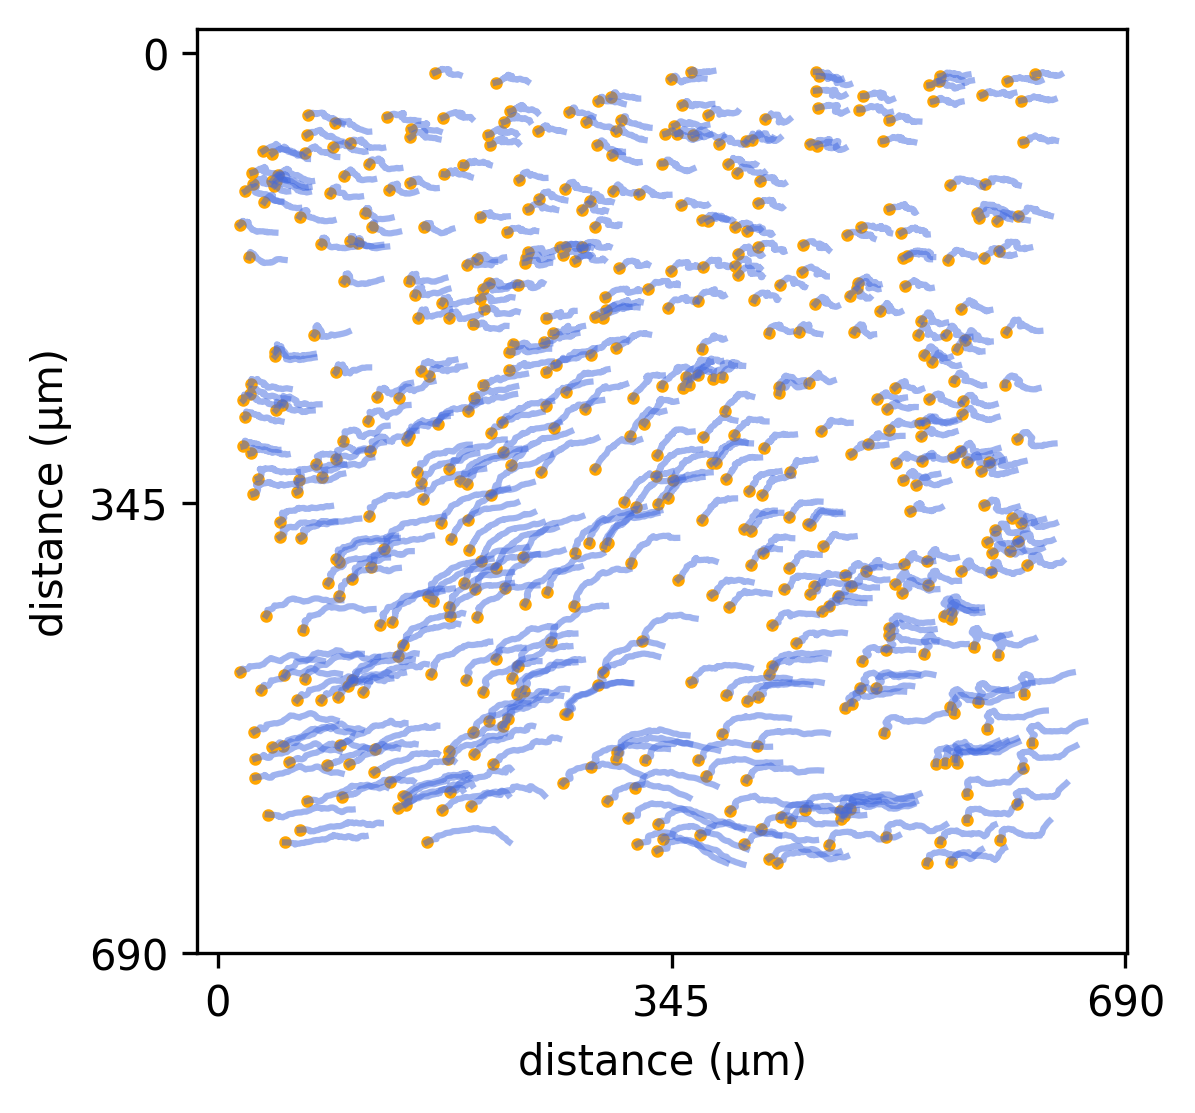

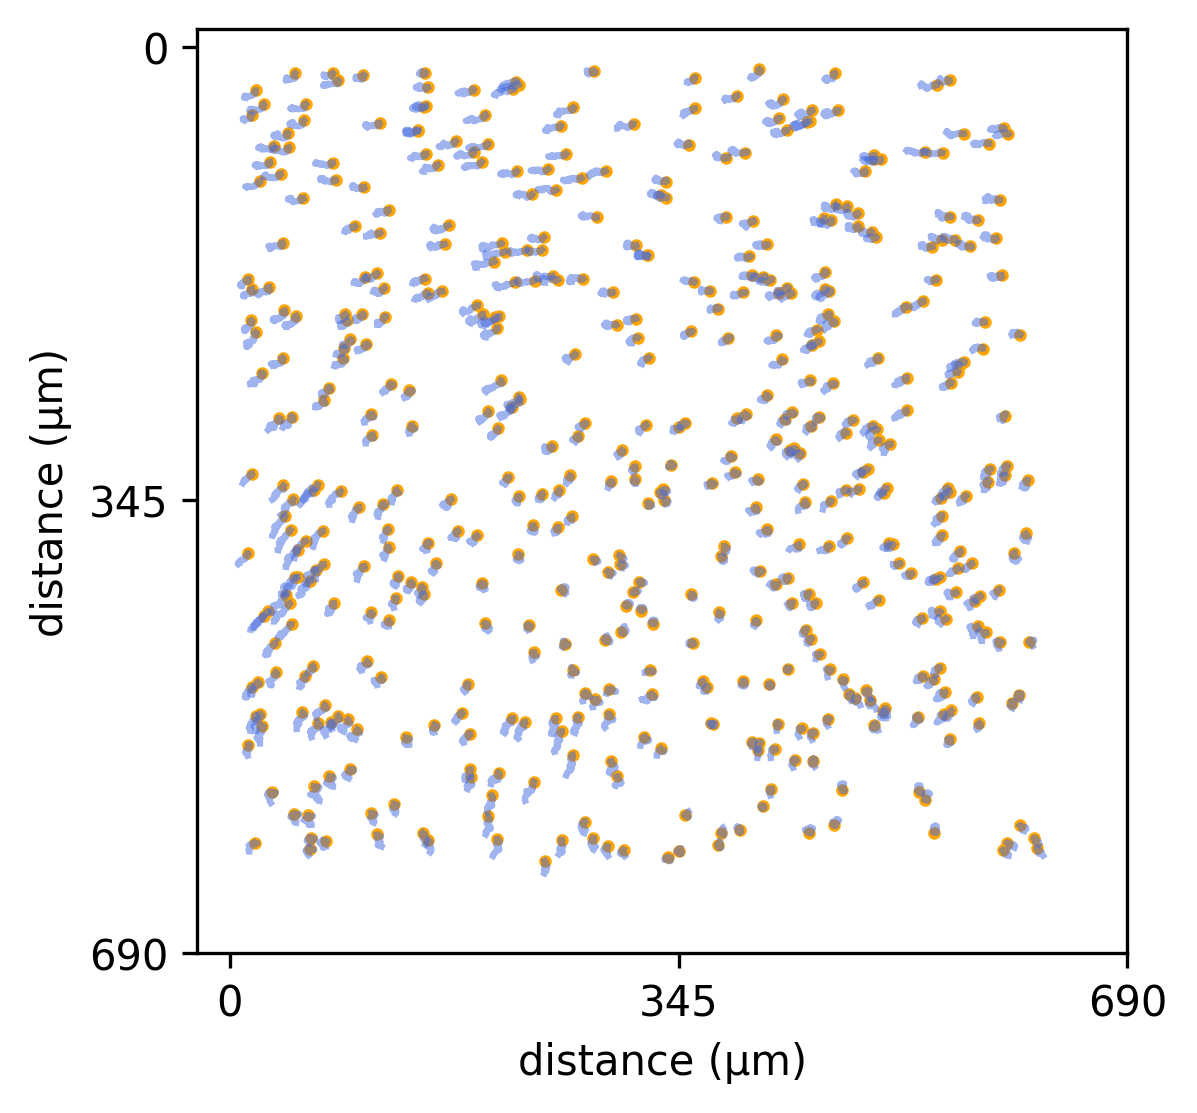

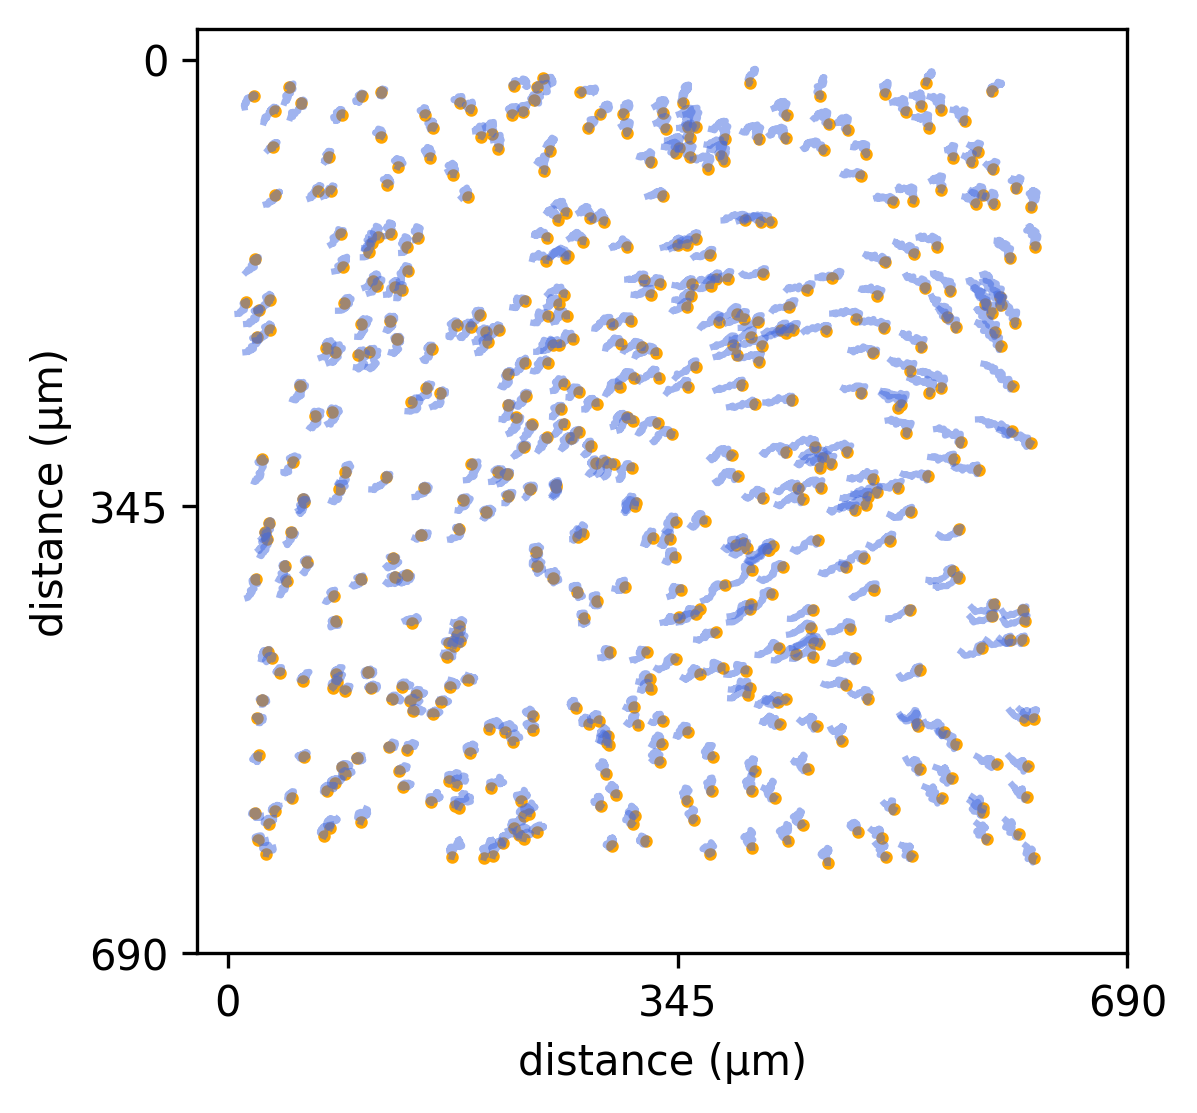

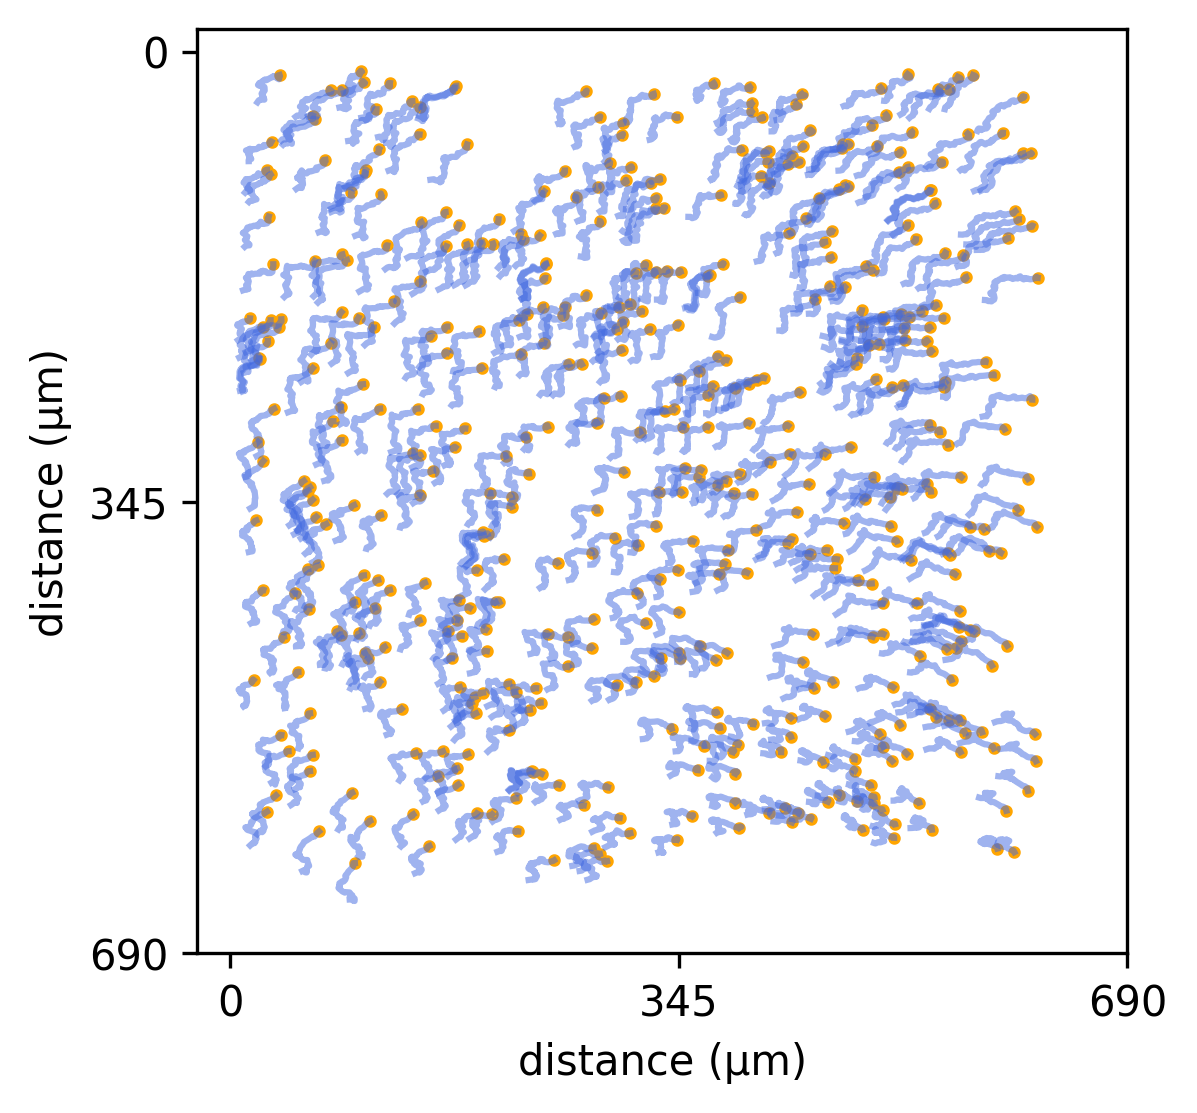

In [9]:
# Results from control data.
x_coords_control_1, y_coords_control_1 = whole_image_pseudo_trajectories(U_control_1, V_control_1, 500, 0, 48, 16, 0.69, "...")
x_coords_control_2, y_coords_control_2 = whole_image_pseudo_trajectories(U_control_2, V_control_2, 500, 0, 48, 16, 0.69, "...")
x_coords_control_3_condensate_cut, y_coords_control_3_condensate_cut = whole_image_pseudo_trajectories(U_control_3_condensate_cut, 
                                                                        V_control_3_condensate_cut, 500, 0, 48, 16, 0.69, "...")

# Calculate the angles for each control dataset. 
angles_control_1, length_control_1 = displace_angle_multiple_tracks(x_coords_control_1, y_coords_control_1)
angles_control_2, length_control_2 = displace_angle_multiple_tracks(x_coords_control_2, y_coords_control_2)
angles_control_3, length_control_3 = displace_angle_multiple_tracks(x_coords_control_3_condensate_cut, 
                                                                    y_coords_control_3_condensate_cut)

all_angles_control = np.array([angles_control_1, angles_control_2, angles_control_3])
all_length_control = np.array([length_control_1, length_control_2, length_control_3])

# Results from DAPT data.
x_coords_DAPT_1, y_coords_DAPT_1 = whole_image_pseudo_trajectories(U_DAPT_1, V_DAPT_1, 500, 0, 48, 16, 0.69, "...")
x_coords_DAPT_2, y_coords_DAPT_2 = whole_image_pseudo_trajectories(U_DAPT_2, V_DAPT_2, 500, 0, 48, 16, 0.69, "...")
x_coords_DAPT_3, y_coords_DAPT_3 = whole_image_pseudo_trajectories(U_DAPT_3, V_DAPT_3, 500, 0, 48, 16, 0.69, "...")

# Calculate the angles for each DAPT dataset. 
angles_DAPT_1, length_DAPT_1 = displace_angle_multiple_tracks(x_coords_DAPT_1, y_coords_DAPT_1)
angles_DAPT_2, length_DAPT_2 = displace_angle_multiple_tracks(x_coords_DAPT_2, y_coords_DAPT_2)
angles_DAPT_3, length_DAPT_3 = displace_angle_multiple_tracks(x_coords_DAPT_3, y_coords_DAPT_3)

all_angles_DAPT = np.array([angles_DAPT_1, angles_DAPT_2, angles_DAPT_3])
all_length_DAPT = np.array([length_DAPT_1, length_DAPT_2, length_DAPT_3])

# Results from RA data. 
x_coords_RA_1, y_coords_RA_1 = whole_image_pseudo_trajectories(U_RA_1, V_RA_1, 500, 0, 48, 16, 0.69, "...")
x_coords_RA_2, y_coords_RA_2 = whole_image_pseudo_trajectories(U_RA_2, V_RA_2, 500, 0, 48, 16, 0.69, "...")
x_coords_RA_4, y_coords_RA_4 = whole_image_pseudo_trajectories(U_RA_4, V_RA_4, 500, 0, 48, 16, 0.69, "...")

# Calulate the angles for each RA data.
angles_RA_1, length_RA_1 = displace_angle_multiple_tracks(x_coords_RA_1, y_coords_RA_1)
angles_RA_2, length_RA_2 = displace_angle_multiple_tracks(x_coords_RA_2, y_coords_RA_2)
angles_RA_4, length_RA_4 = displace_angle_multiple_tracks(x_coords_RA_4, y_coords_RA_4)

all_angles_RA = np.array([angles_RA_1, angles_RA_2, angles_RA_4])
all_length_RA = np.array([length_RA_1, length_RA_2, length_RA_4])

In [44]:
def rose_plot_overlap_dataset(all_dataset_angle_array, img_name):
    # With an array containing arrays of angles for each dataset, generate a final rose plot overlapping the distributions. 
    
    # General settings of the rose plot. 
    num_bins = 30
    bins = np.linspace(-np.pi, np.pi, num_bins + 1)

    # Create the polar plot, with histogram counting the number of vectors pointing to the corresponding direction. 
    # Histogram bars are colored by the mean velocity of vectors in each bar/bin. 
    fig = plt.figure(figsize=(3, 3), dpi=300)
    ax = plt.subplot(111, projection='polar')
    ax.grid(linestyle = "-.", linewidth=0.3)
    # Customize the grid. 
    ax.set_yticks([50, 100])
    ax.set_xticks([1/2*np.pi, 3/2*np.pi], ["A", "P"], fontsize=15)

    # For each dataset generate histogramms in rose plot. 
    for i in range(len(all_dataset_angle_array)):
        counts, bin_edges, patches = ax.hist(all_dataset_angle_array[i], bins=num_bins, range=(-np.pi, np.pi), edgecolor='white', alpha=0.6)

    plt.savefig(img_name, format="svg")

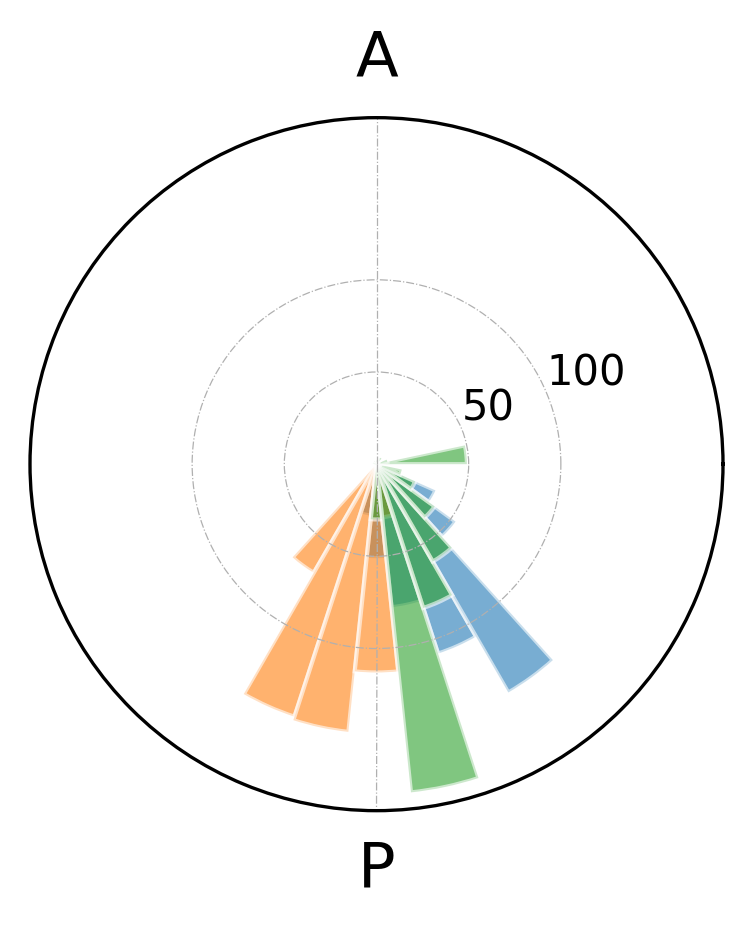

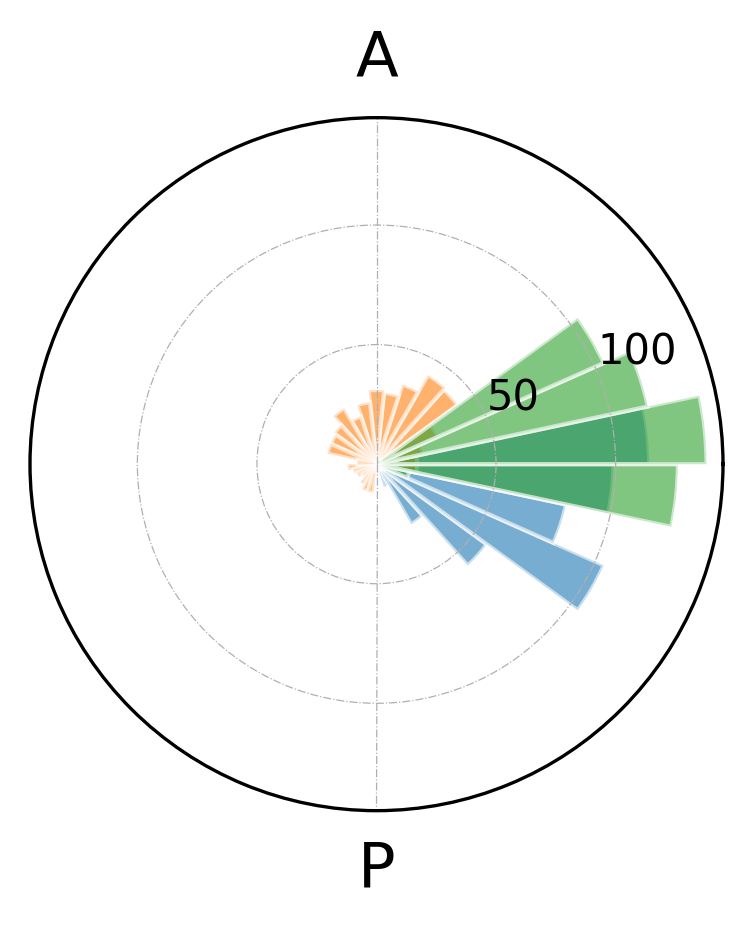

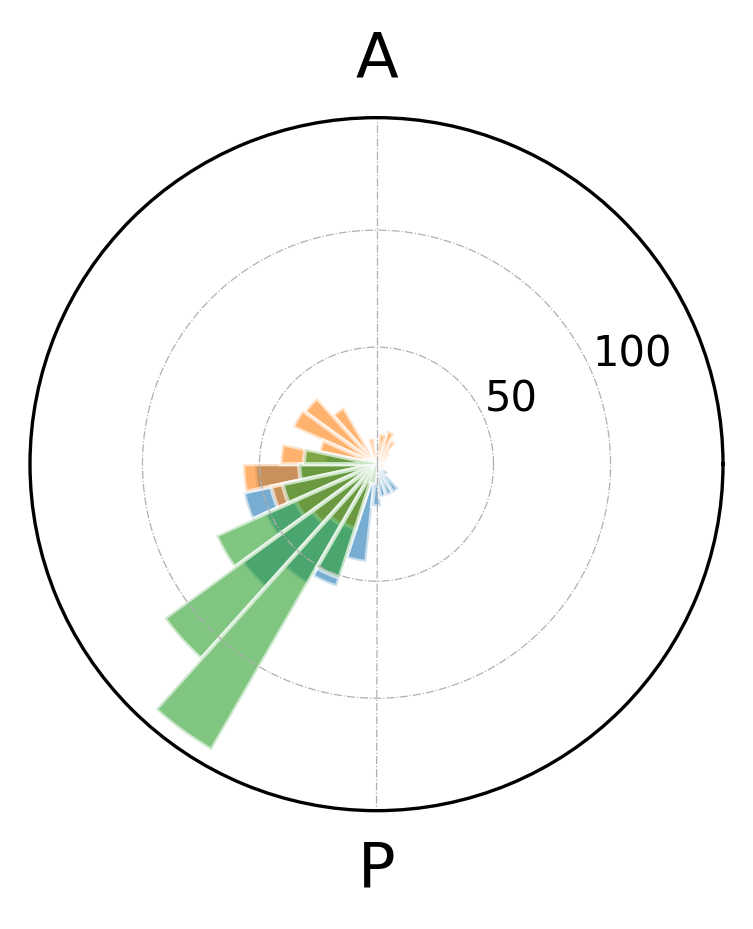

In [45]:
rose_plot_overlap_dataset(all_angles_control, "polar_angle_control.svg")
rose_plot_overlap_dataset(all_angles_DAPT, "polar_angle_DAPT.svg")
rose_plot_overlap_dataset(all_angles_RA, "polar_angle_RA.svg")

In [42]:
def polar_line_plot_overlap_dataset(all_dataset_angle_array, all_dataset_length_array, pxl_conversion, img_name):
    # With an array containing arrays of angles for each dataset, generate a final rose plot overlapping the distributions. 

    all_pxl_length = all_dataset_length_array * pxl_conversion # Tranform the length into real distance through pixel conversion. 
    # Create the polar plot, with histogram counting the number of vectors pointing to the corresponding direction. 
    # Histogram bars are colored by the mean velocity of vectors in each bar/bin. 
    fig = plt.figure(figsize=(3, 3), dpi=300)
    ax = plt.subplot(111, projection='polar')

    # Define the colors available for all datasets. Give a color for each dataset. 
    n = len(all_dataset_angle_array)
    colors = plt.cm.jet(np.linspace(0,1,n))

    # For each dataset generate lines in polar plot. 
    for i in range(len(all_dataset_angle_array)):
        
        current_angle_array = all_dataset_angle_array[i]
        current_length_array = all_pxl_length[i]

        for j in range(len(current_angle_array)):
            ax.plot([current_angle_array[j], current_angle_array[j]], [0, current_length_array[j]], color=colors[i], linewidth=1, alpha=0.3)

    # Customize the grid. 
    ax.grid(linestyle = "-.", linewidth=0.3)
    ax.set_yticks([round(np.mean(all_pxl_length)), 100], [str(round(np.mean(all_pxl_length))) + "μm", str(100)+"μm"])
    ax.set_ylim([0, 103]) # 103 = np.max(all_length_control*0.69)
    ax.set_rlabel_position(90)
    ax.set_xticks([1/2*np.pi, 3/2*np.pi], ["A", "P"], fontsize=15)

    plt.savefig(img_name, format="svg")

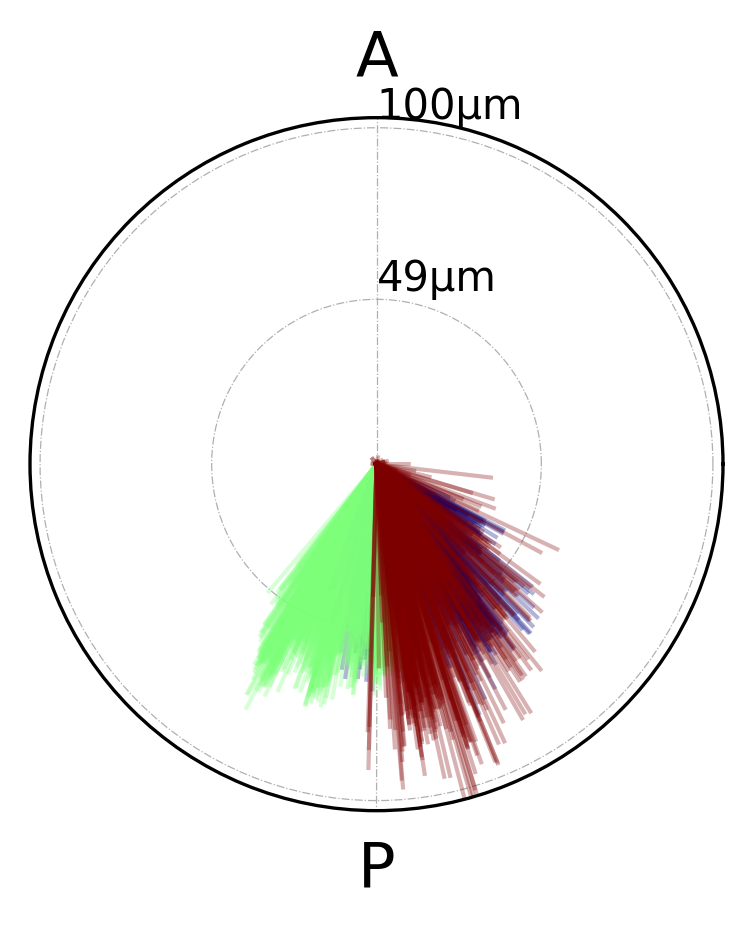

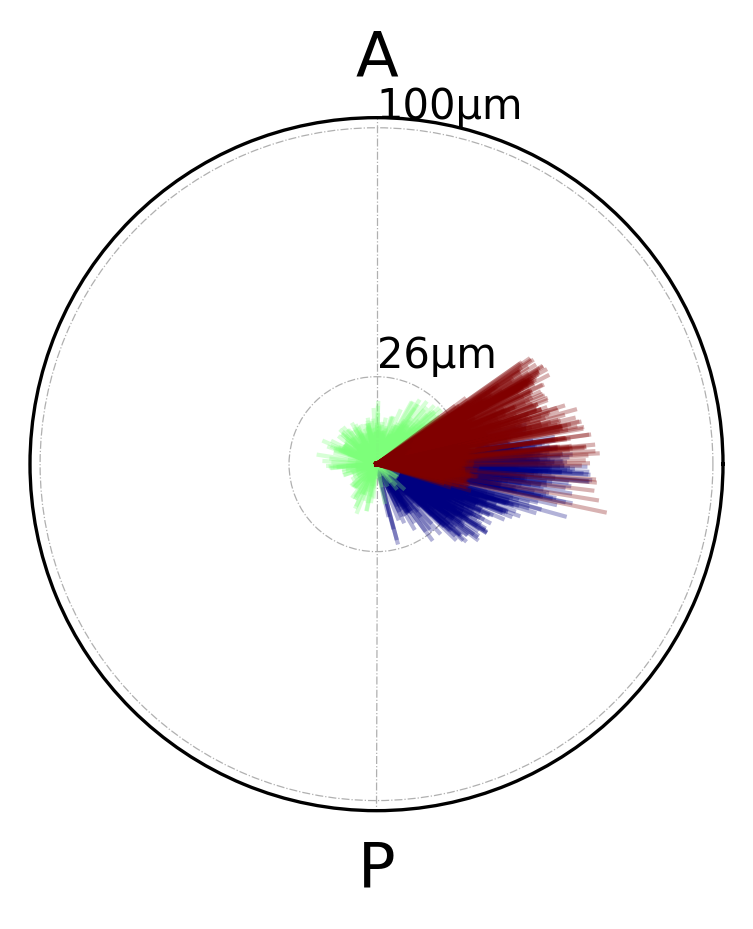

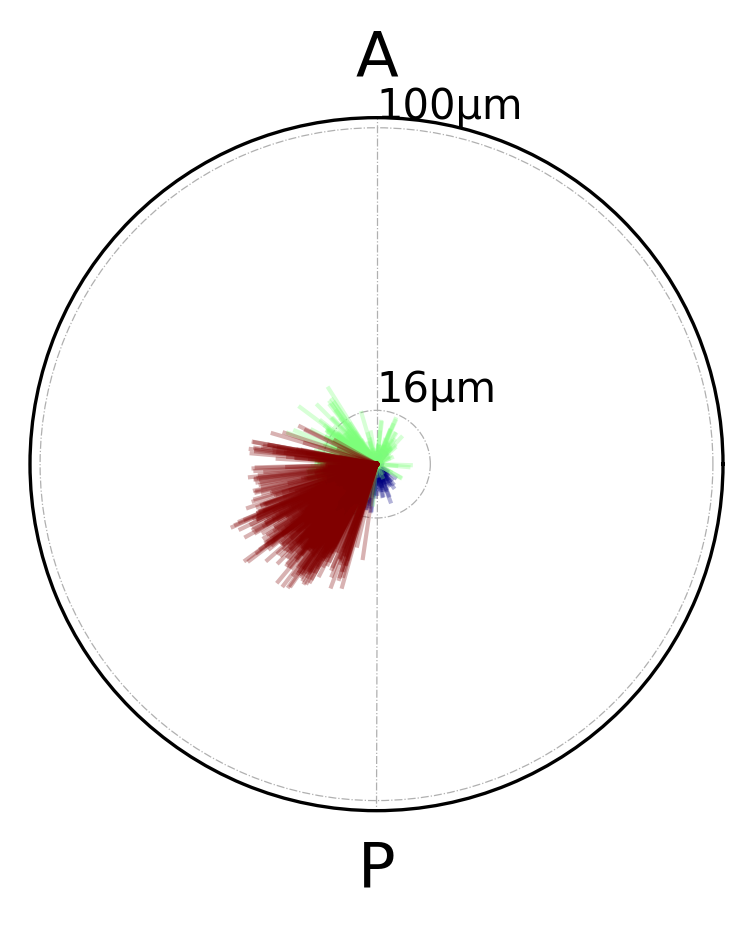

In [43]:
polar_line_plot_overlap_dataset(all_angles_control, all_length_control, 0.69, "polar_line_memGFP_control_pseudo_track.svg")
polar_line_plot_overlap_dataset(all_angles_DAPT, all_length_DAPT, 0.69, "polar_line_memGFP_DAPT_pseudo_track.svg")
polar_line_plot_overlap_dataset(all_angles_RA, all_length_RA, 0.69, "polar_line_memGFP_RA_pseudo_track.svg")

In [37]:
np.max(all_length_control*0.69)

np.float64(102.90226413768632)